In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install skan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 125.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 38.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.2 which is incompatible.


In [94]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import morphology
import skan
import pandas as pd
from skimage.morphology import medial_axis
import os

def filter_small_structures(dilated_mask):

    # Identify connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_mask, connectivity=8)

    #areas = stats[1:, cv2.CC_STAT_AREA]
    #mean_squares_areas = np.sum(areas**2)/len(areas)

    # Define a threshold size (adjust as needed)
    img_size = dilated_mask.shape[0]*dilated_mask.shape[1]
    print(img_size)
    min_component_size = max(stats[1:, cv2.CC_STAT_AREA].mean() - stats[1:, cv2.CC_STAT_AREA].std(), 0.0009*img_size)

    # Filter out smaller components
    filtered_mask = np.zeros_like(dilated_mask)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_component_size:
            filtered_mask[labels == label] = 255

    # Show the result
    cv2_imshow(filtered_mask)
    return filtered_mask

def filter_thin_structures(mask, kernel_size = 3):
    n = kernel_size

    # Step 1: Apply morphological erosion

    kernel = np.ones((n,n),np.uint8)  # Define a square structuring element of size nxn
    eroded_mask = cv2.erode(mask, kernel, iterations=1)

    # Step 2: Apply morphological dilation

    dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=1)

    # Show the result
    #cv2_imshow(dilated_mask)


    return dilated_mask

def skeleton_pruning(mask):
  # Compute the medial axis (skeleton) and the distance transform
  skel, distance = medial_axis(mask, return_distance=True)

  # Distance to the background for pixels of the skeleton
  dist_on_skel = distance * skel

  # Draw
  _, binary_skel = cv2.threshold(dist_on_skel, 1, 255, cv2.THRESH_BINARY)
  #cv2_imshow(binary_skel)

  #Branch data extraction
  sk = skan.csr.Skeleton(dist_on_skel, value_is_height=True)
  original_branch_data = skan.summarize(sk)

  mean_thickness = original_branch_data['mean-pixel-value'].mean()
  std_thickness = original_branch_data['mean-pixel-value'].std()

  mean_distance = original_branch_data['branch-distance'].mean()
  std_distance = original_branch_data['branch-distance'].std()


  # Calculate the thresholds
  threshold_thickness = mean_thickness + 0.3 * std_thickness
  threshold_distance = mean_distance - 0.7 * std_distance

  # Filter the DataFrame
  filtered_data1 = original_branch_data[
      (original_branch_data['mean-pixel-value'] < threshold_thickness) |
      (original_branch_data['branch-distance'] < threshold_distance)
  ]

  # Filter the skeleton
  sk = sk.prune_paths(filtered_data1.index)

  sk2 = sk
  for i in range(4):
    # Assuming 'skeleton' is your skeleton graph
    branch_data = skan.summarize(sk)

    # Filter thin branches
    mean_thickness = branch_data['mean-pixel-value'].mean()
    print(mean_thickness)
    std_thickness = branch_data['mean-pixel-value'].std()
    threshold_thickness = mean_thickness - std_thickness

    filtered_data = branch_data[branch_data['mean-pixel-value'] < threshold_thickness]
    sk = sk.prune_paths(filtered_data.index)
    branch_data = skan.summarize(sk)

    # Calculate the mean of the 'branch-distance' column
    mean_distance = branch_data['branch-distance'].mean()
    std_distance = branch_data['branch-distance'].std()
    threshold_distance = mean_distance + 2 * std_distance

    # Filter rows where 'branch-type' is 1 and 'branch-distance' is no greater than the mean
    filtered_branch_data = branch_data[(branch_data['branch-type'] == 1) &
                                       ~(branch_data['branch-distance'] > threshold_distance) &
                                       ~(branch_data['mean-pixel-value'] > threshold_thickness)
                                       ]

    sk2 = sk.prune_paths(filtered_branch_data.index)
    sk = sk2

  #Draw
  _, binary_sk = cv2.threshold(sk.skeleton_image, 1, 255, cv2.THRESH_BINARY)
  #cv2_imshow(binary_sk)

  #Return the skeleton minus the filtered skeleton.
  negative = cv2.subtract(dist_on_skel, sk2.skeleton_image)
  _, binary_negative = cv2.threshold(negative, 1, 255, cv2.THRESH_BINARY)

  return binary_sk

def dilate_and_subtract(binary_mask, sk, dilation_radius = 5):
    # Perform dilation on skeleton 'sk'
    kernel = np.ones((dilation_radius, dilation_radius), np.uint8)
    dilated_sk = cv2.dilate(sk.astype(np.uint8), kernel, iterations = 2)
    #cv2_imshow(dilated_sk)

    # Subtract the dilated skeleton from the binary mask
    result_mask = cv2.bitwise_and(binary_mask, dilated_sk)
    cv2_imshow(result_mask)
    return result_mask

def mask_post_processing(input_directory, output_directory):
    # Get a list of all the files in the directory
    files = os.listdir(input_directory)

    # Iterate through the files
    for file_name in files:
        if file_name.endswith('.png'):
            # Read the binary mask
            binary_mask = cv2.imread(os.path.join(input_directory, file_name), cv2.IMREAD_GRAYSCALE)
            cv2_imshow(binary_mask)

            # Apply operations
            sk_negative = skeleton_pruning(binary_mask)
            mask2 = dilate_and_subtract(binary_mask, sk_negative)
            mask3 = filter_small_structures(mask2)

            # Save the resulting mask
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, mask3)

In [ ]:


binary_mask = cv2.imread('/content/drive/MyDrive/few-shot-leaf-segmentation/data/vein_fl_preds/00179829_leaf_1_bot.png', cv2.IMREAD_GRAYSCALE)


sk_negative = skeleton_pruning(binary_mask)
mask2 = dilate_and_subtract(binary_mask, sk_negative)
mask3 = filter_small_structures(mask2)

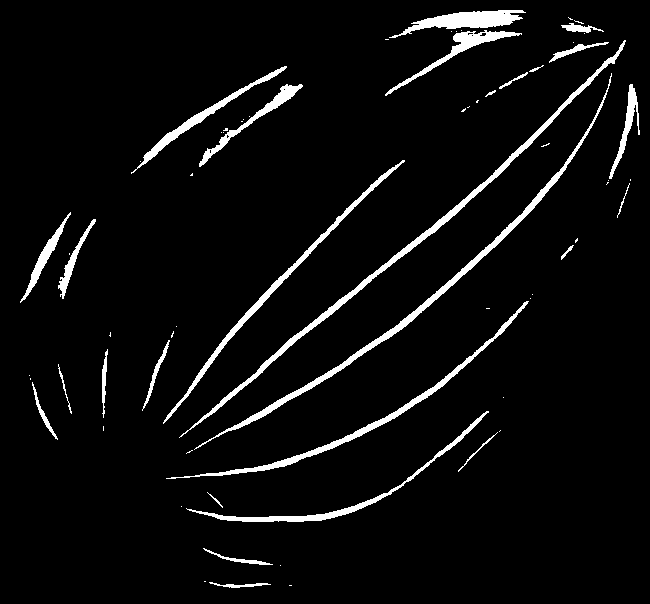

3.719153504367433
3.753960450359118
3.753960450359118
3.753960450359118


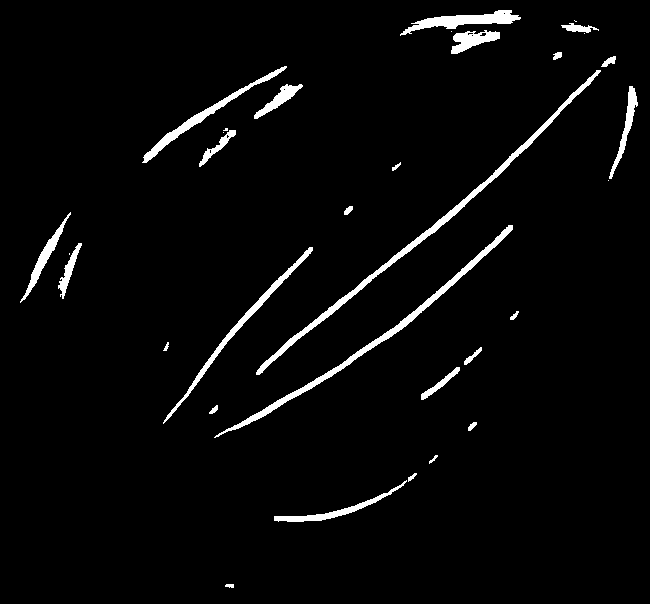

392600


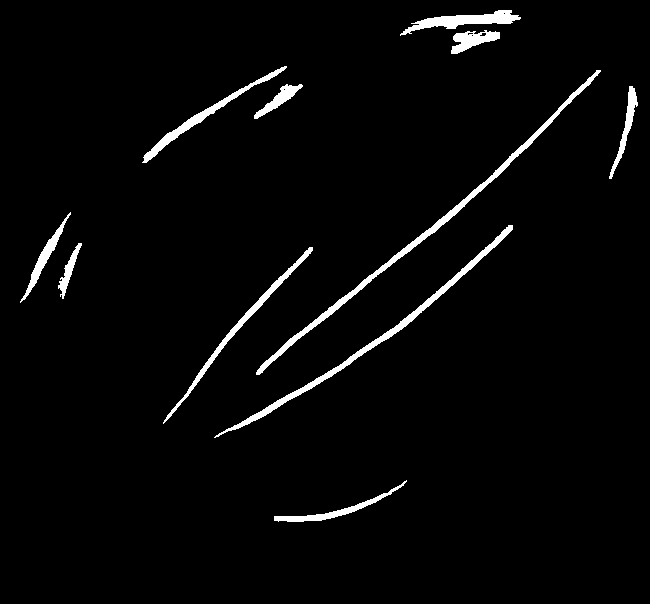

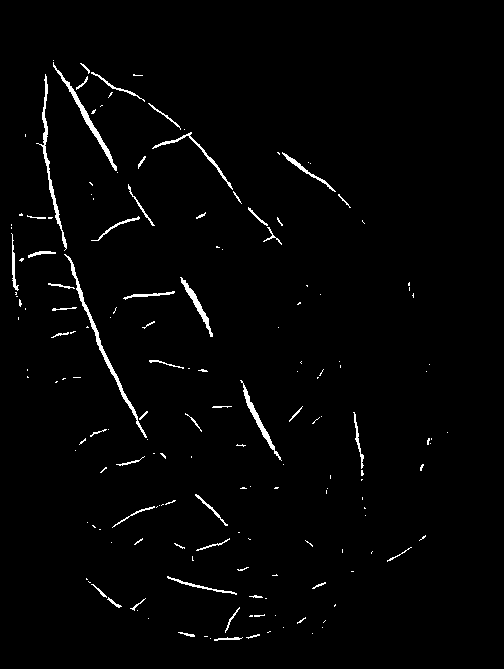

1.664295367775654
1.6734139263141856
1.6874361485191596
1.6988311533196156


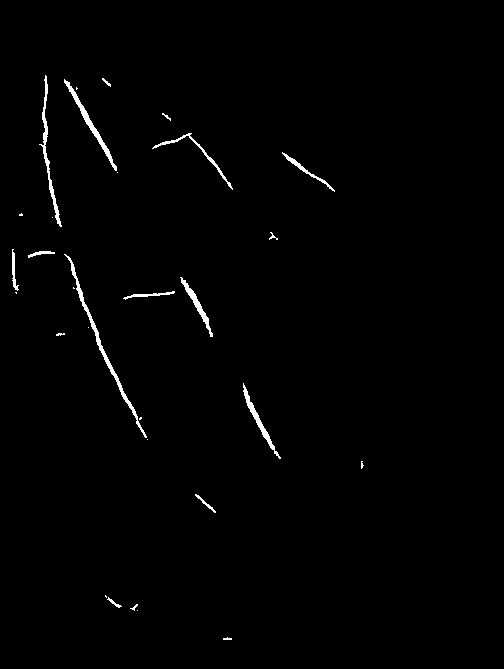

337176


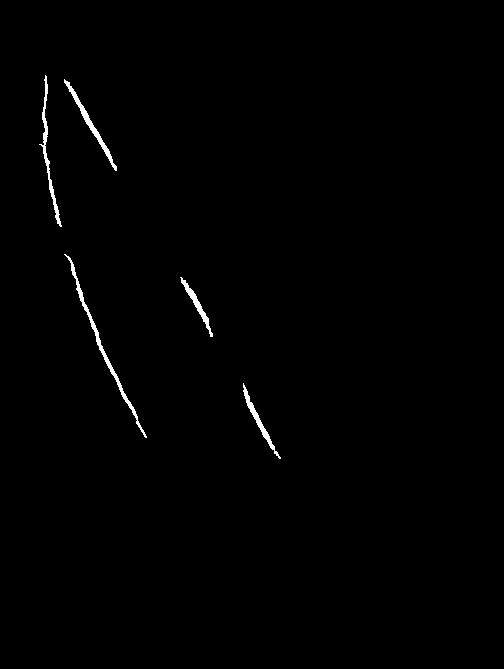

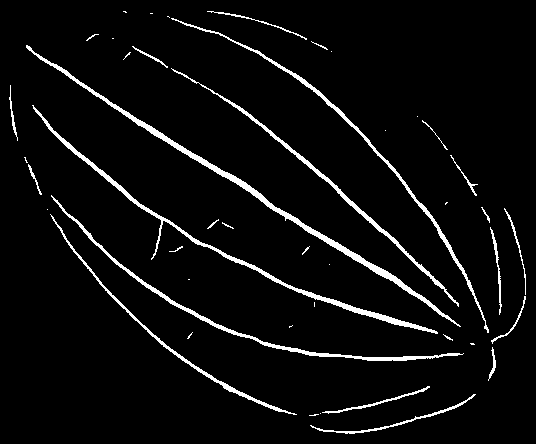

1.810769064612863
1.810769064612863
1.810769064612863
1.810769064612863


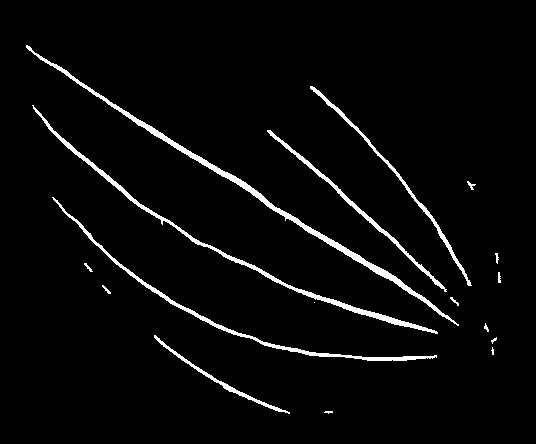

237984


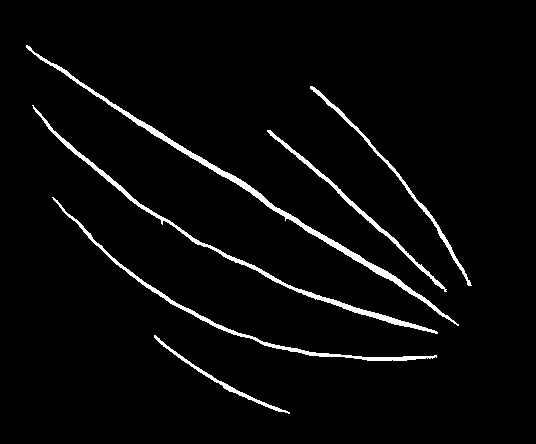

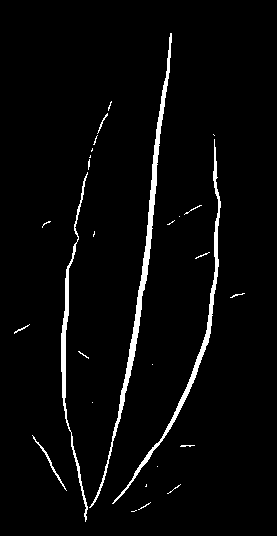

1.978607078594213
1.978607078594213
1.978607078594213
1.978607078594213


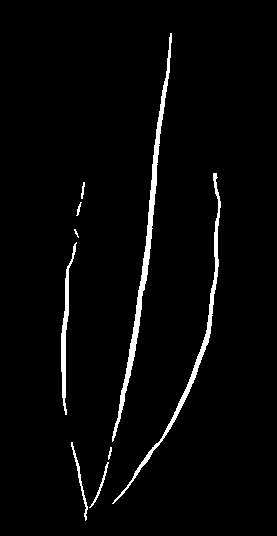

148472


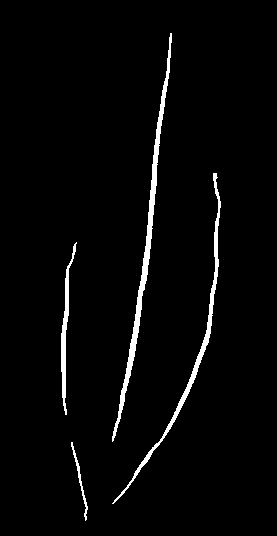

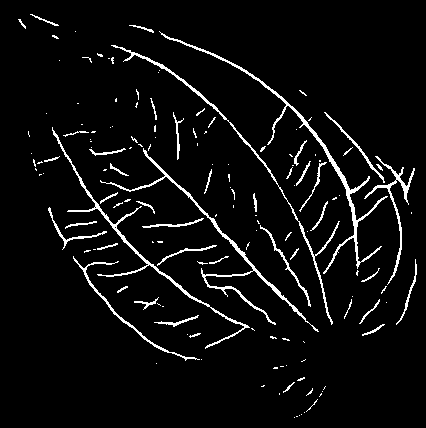

1.5972368854829027
1.6227776791926207
1.6483170909794995
1.6725228229255136


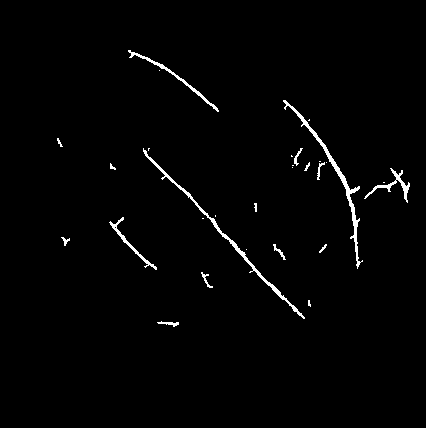

182328


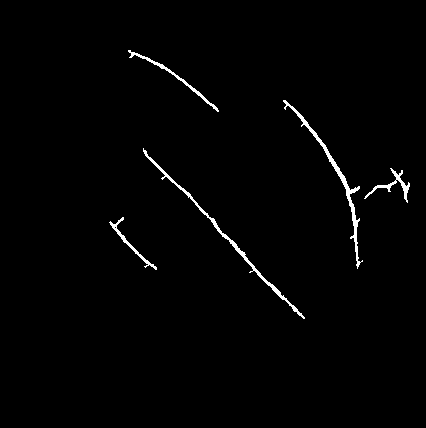

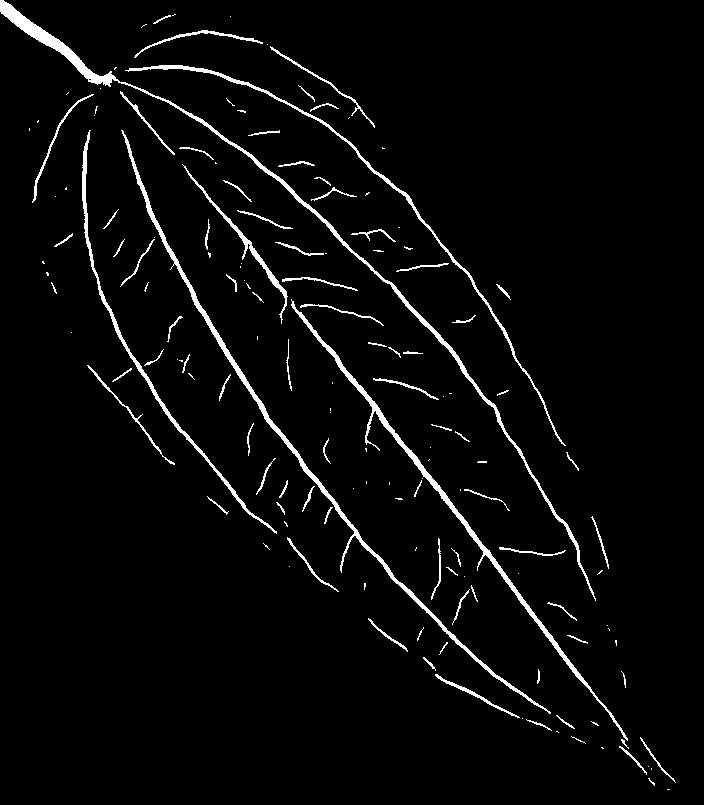

2.779956221728569
2.833700221012555
2.8739824622768446
2.9293813591522353


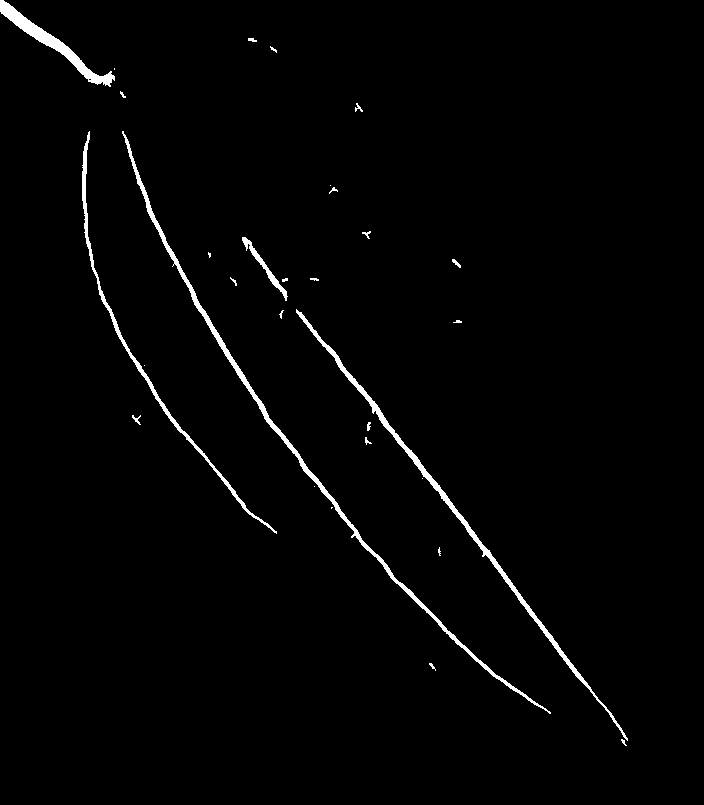

566720


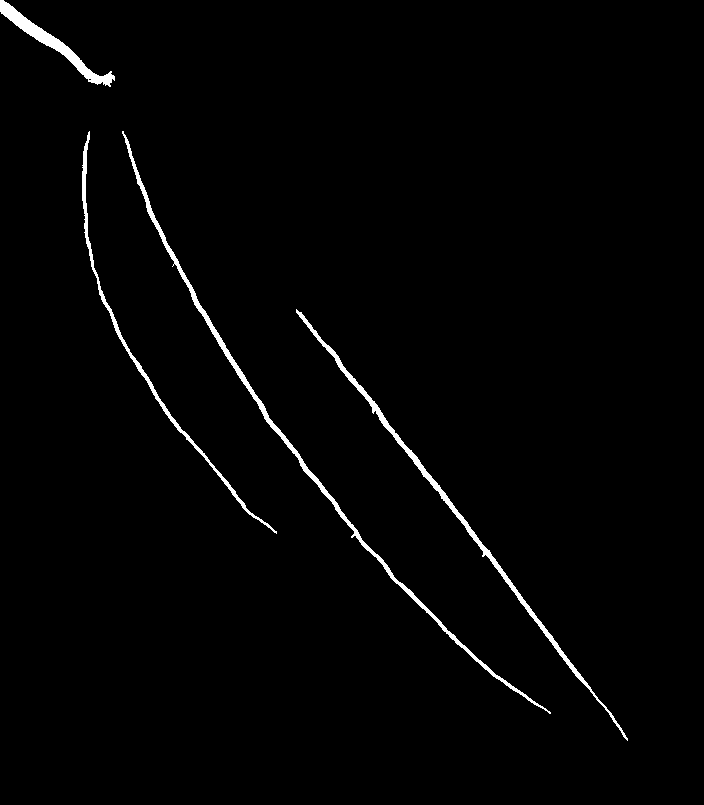

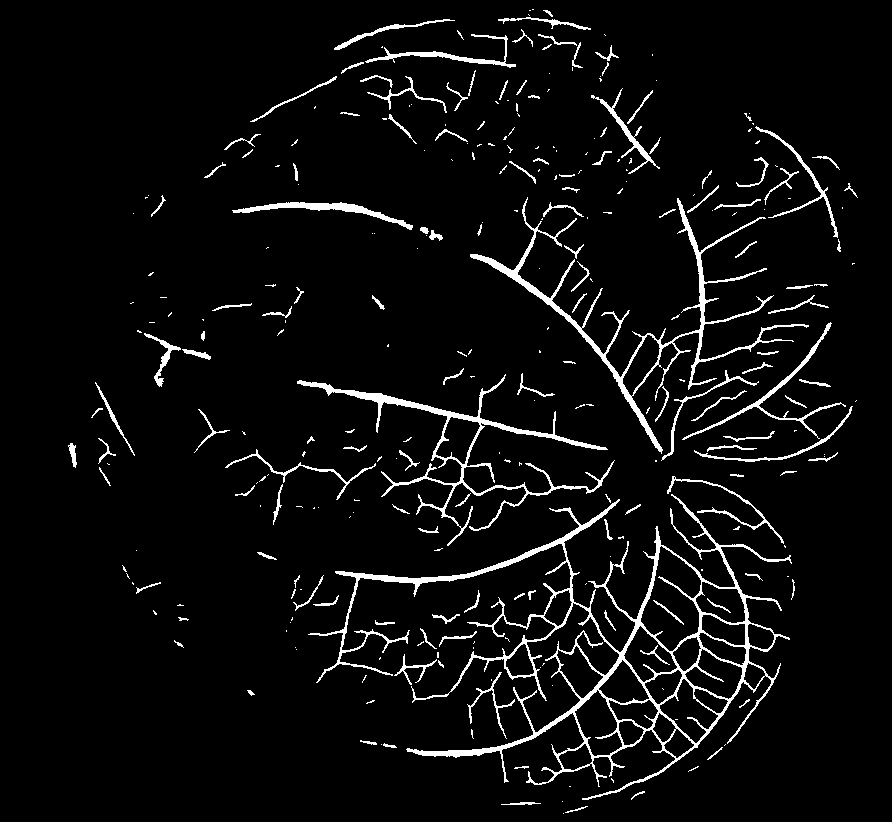

2.069028385286727
2.1151454540675143
2.1805864261718497
2.2394785831214756


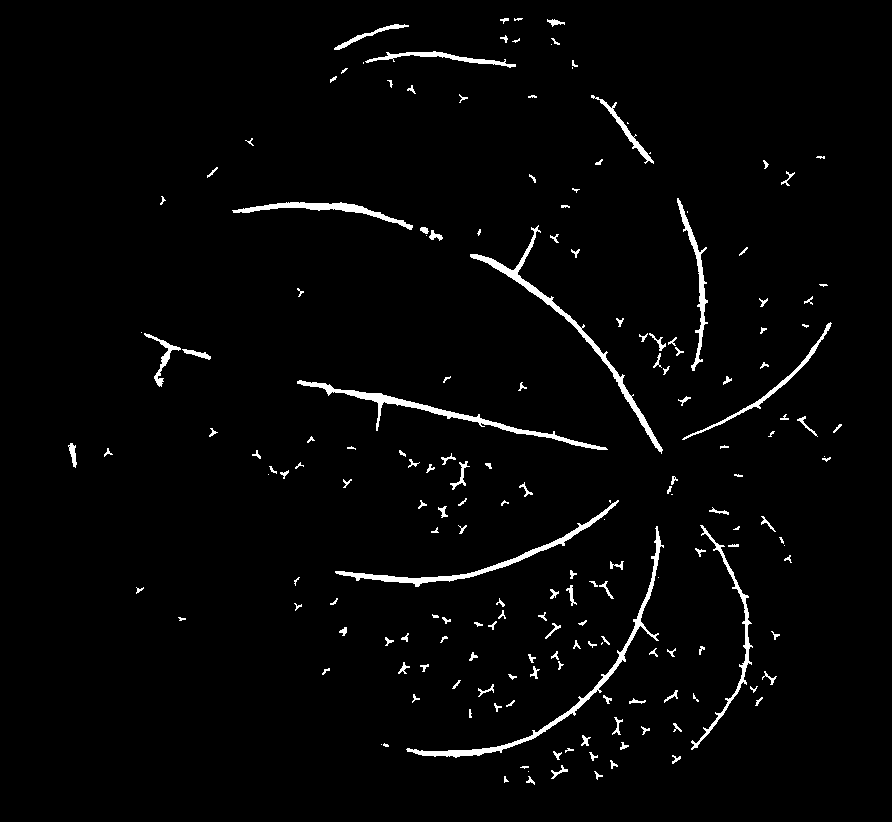

733224


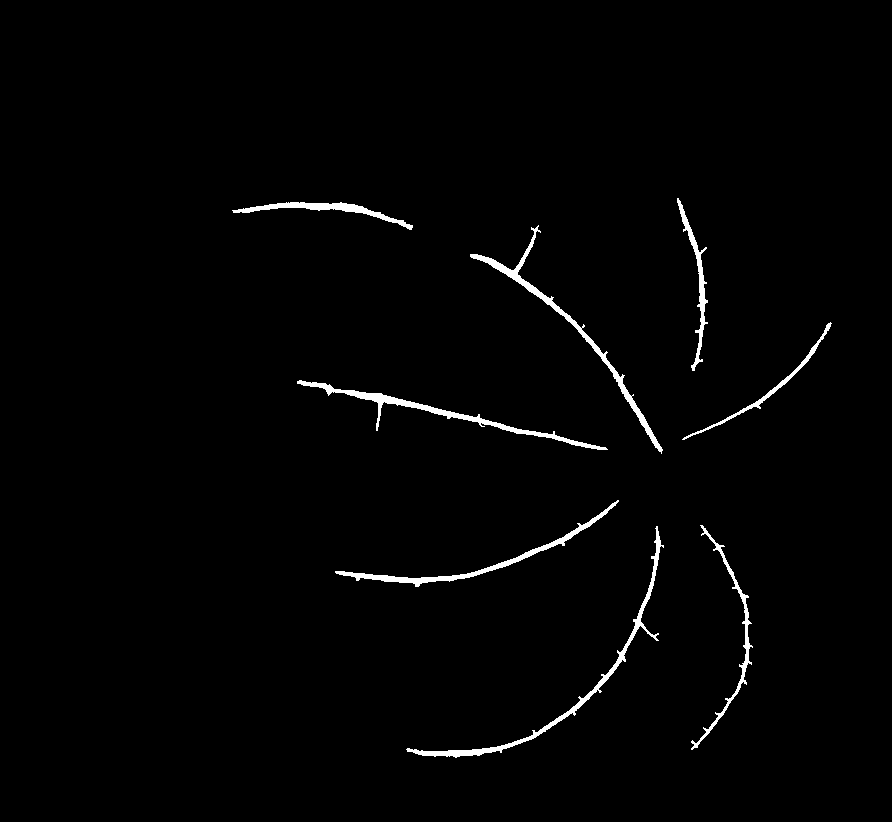

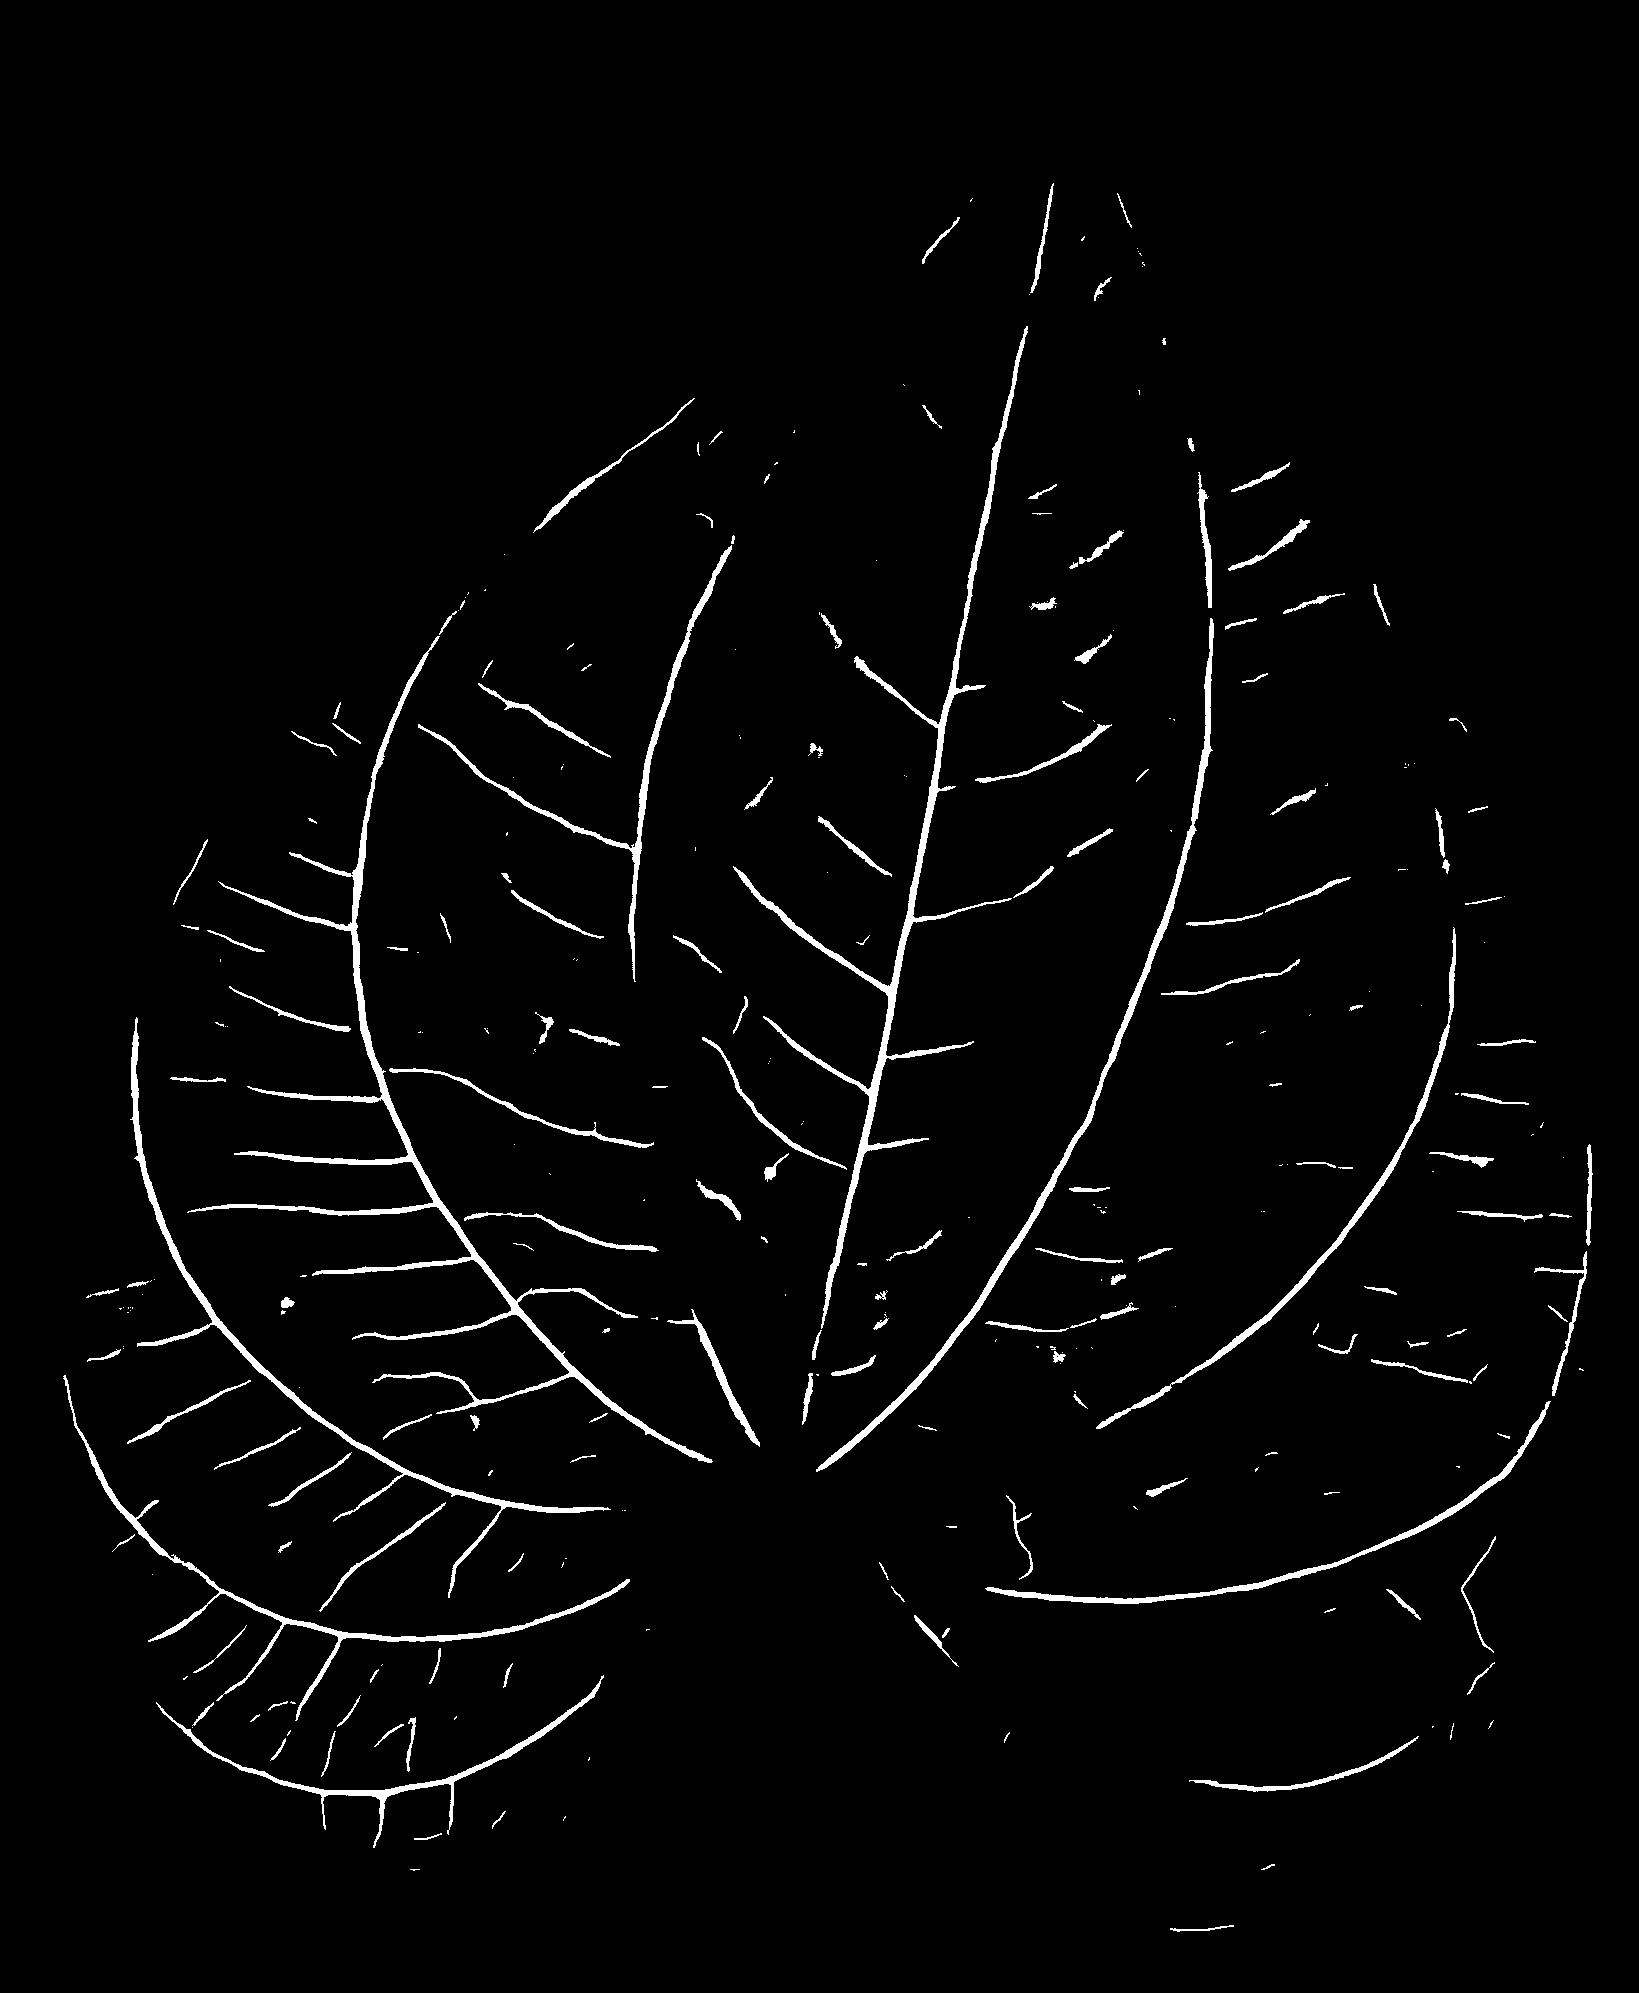

2.5593979911427076
2.5993900831185384
2.6430631564833225
2.6931722465489907


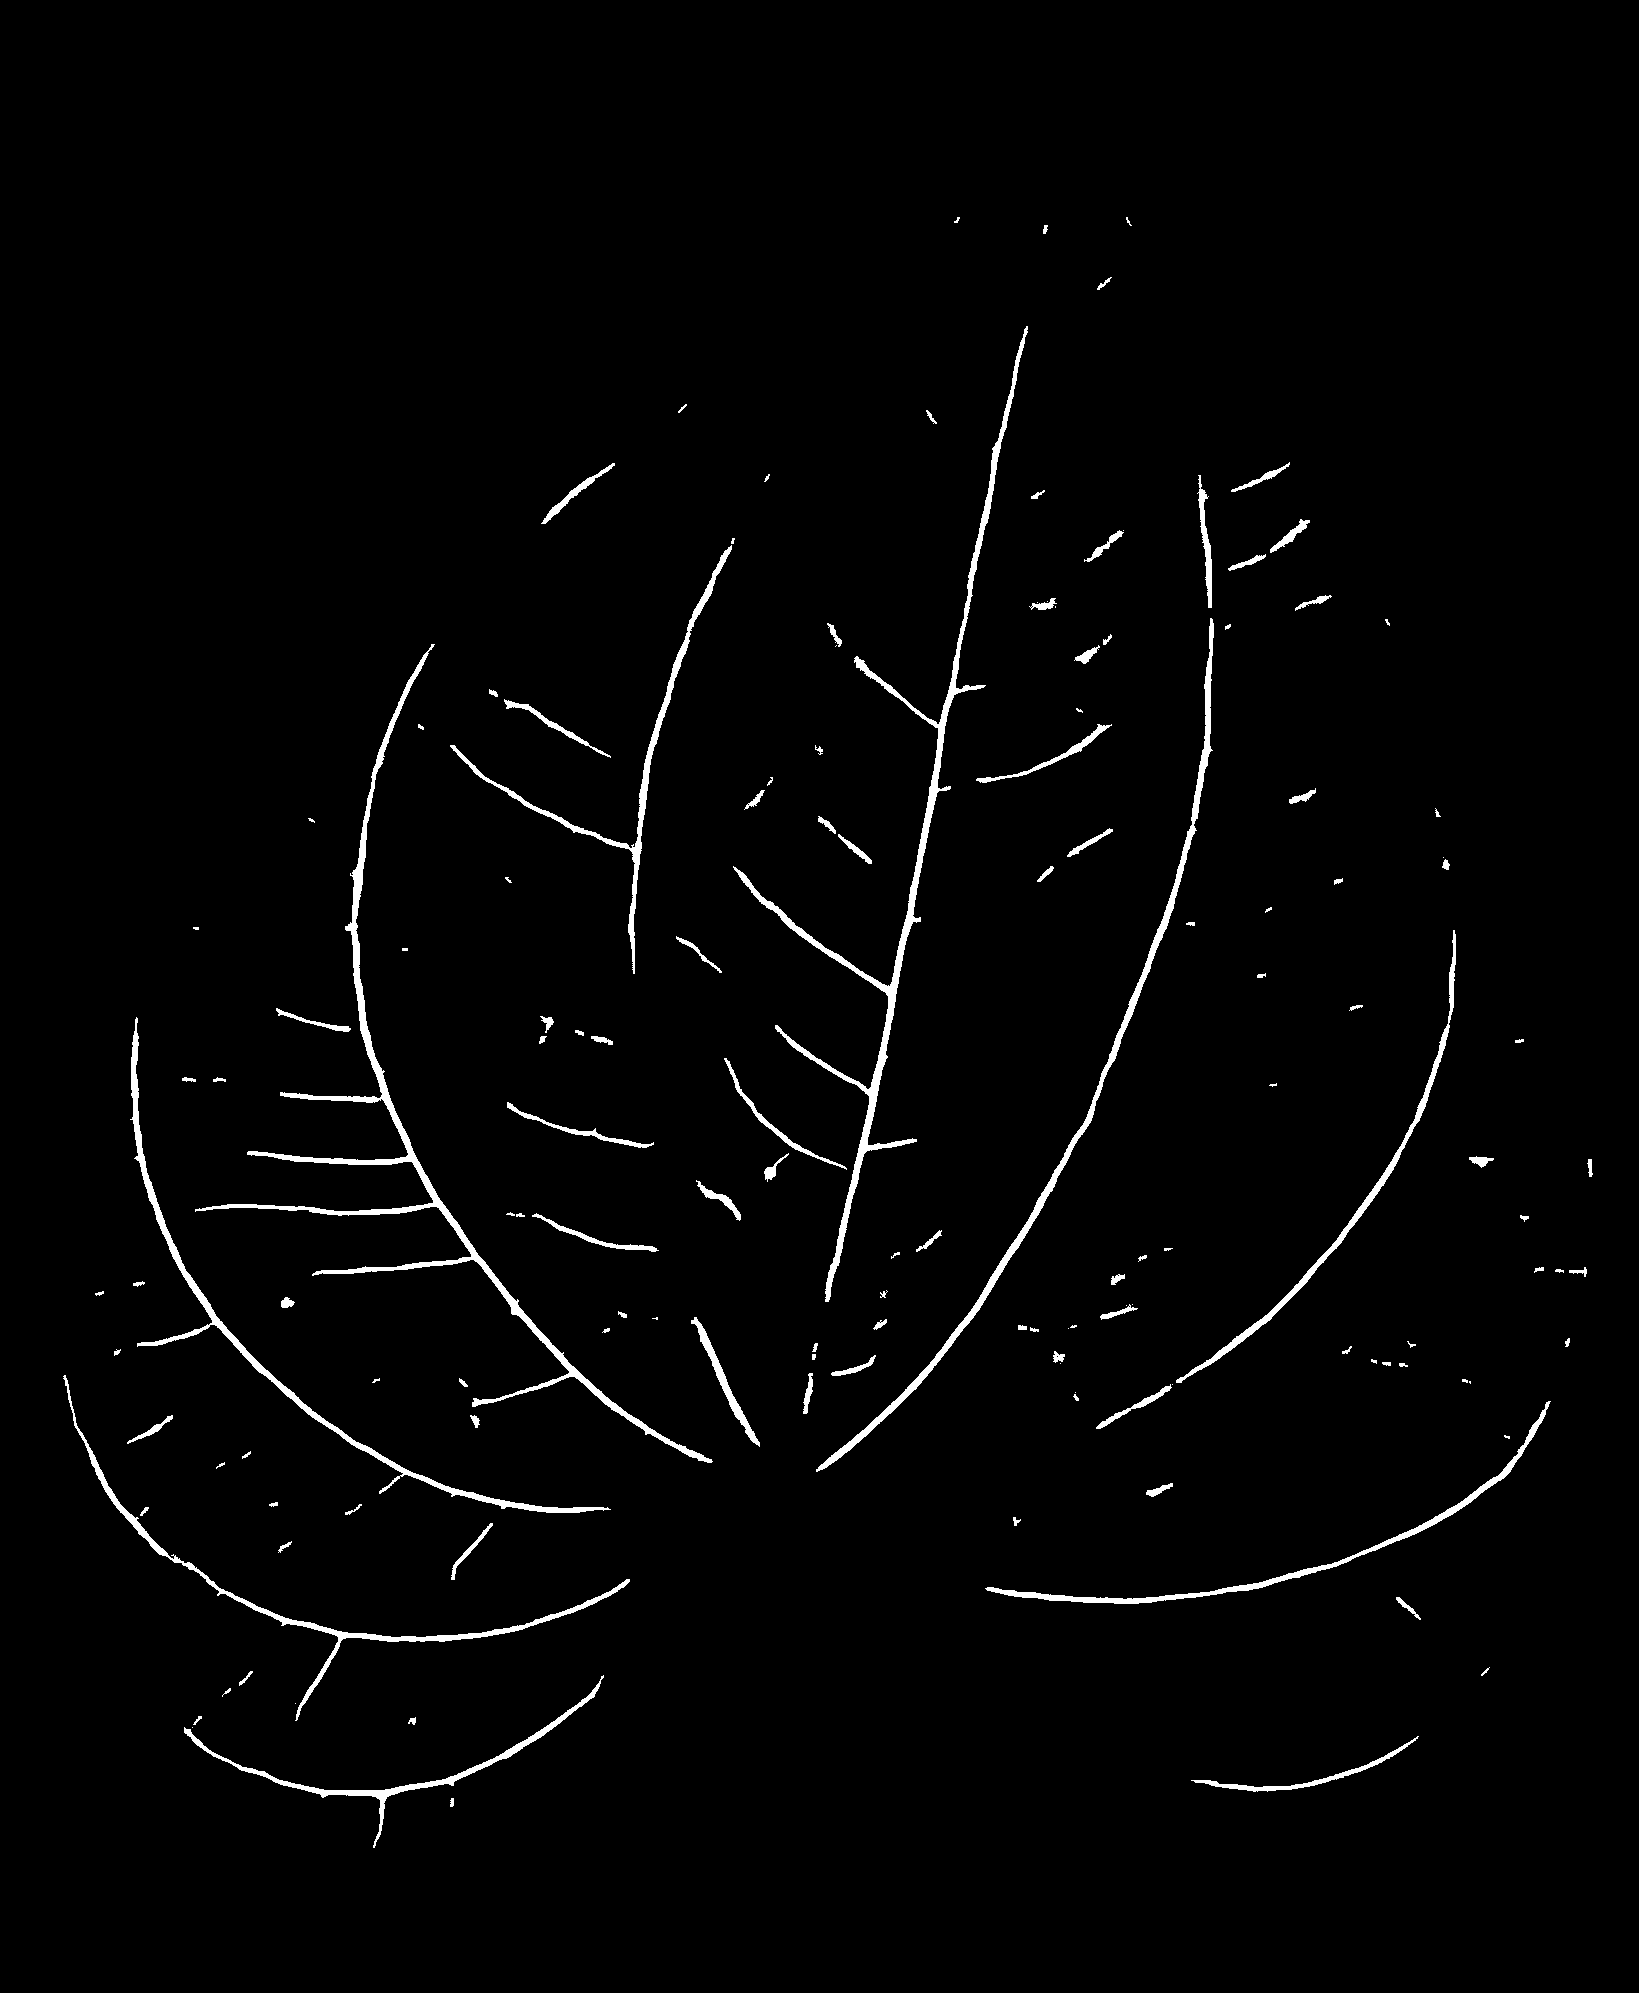

3266527


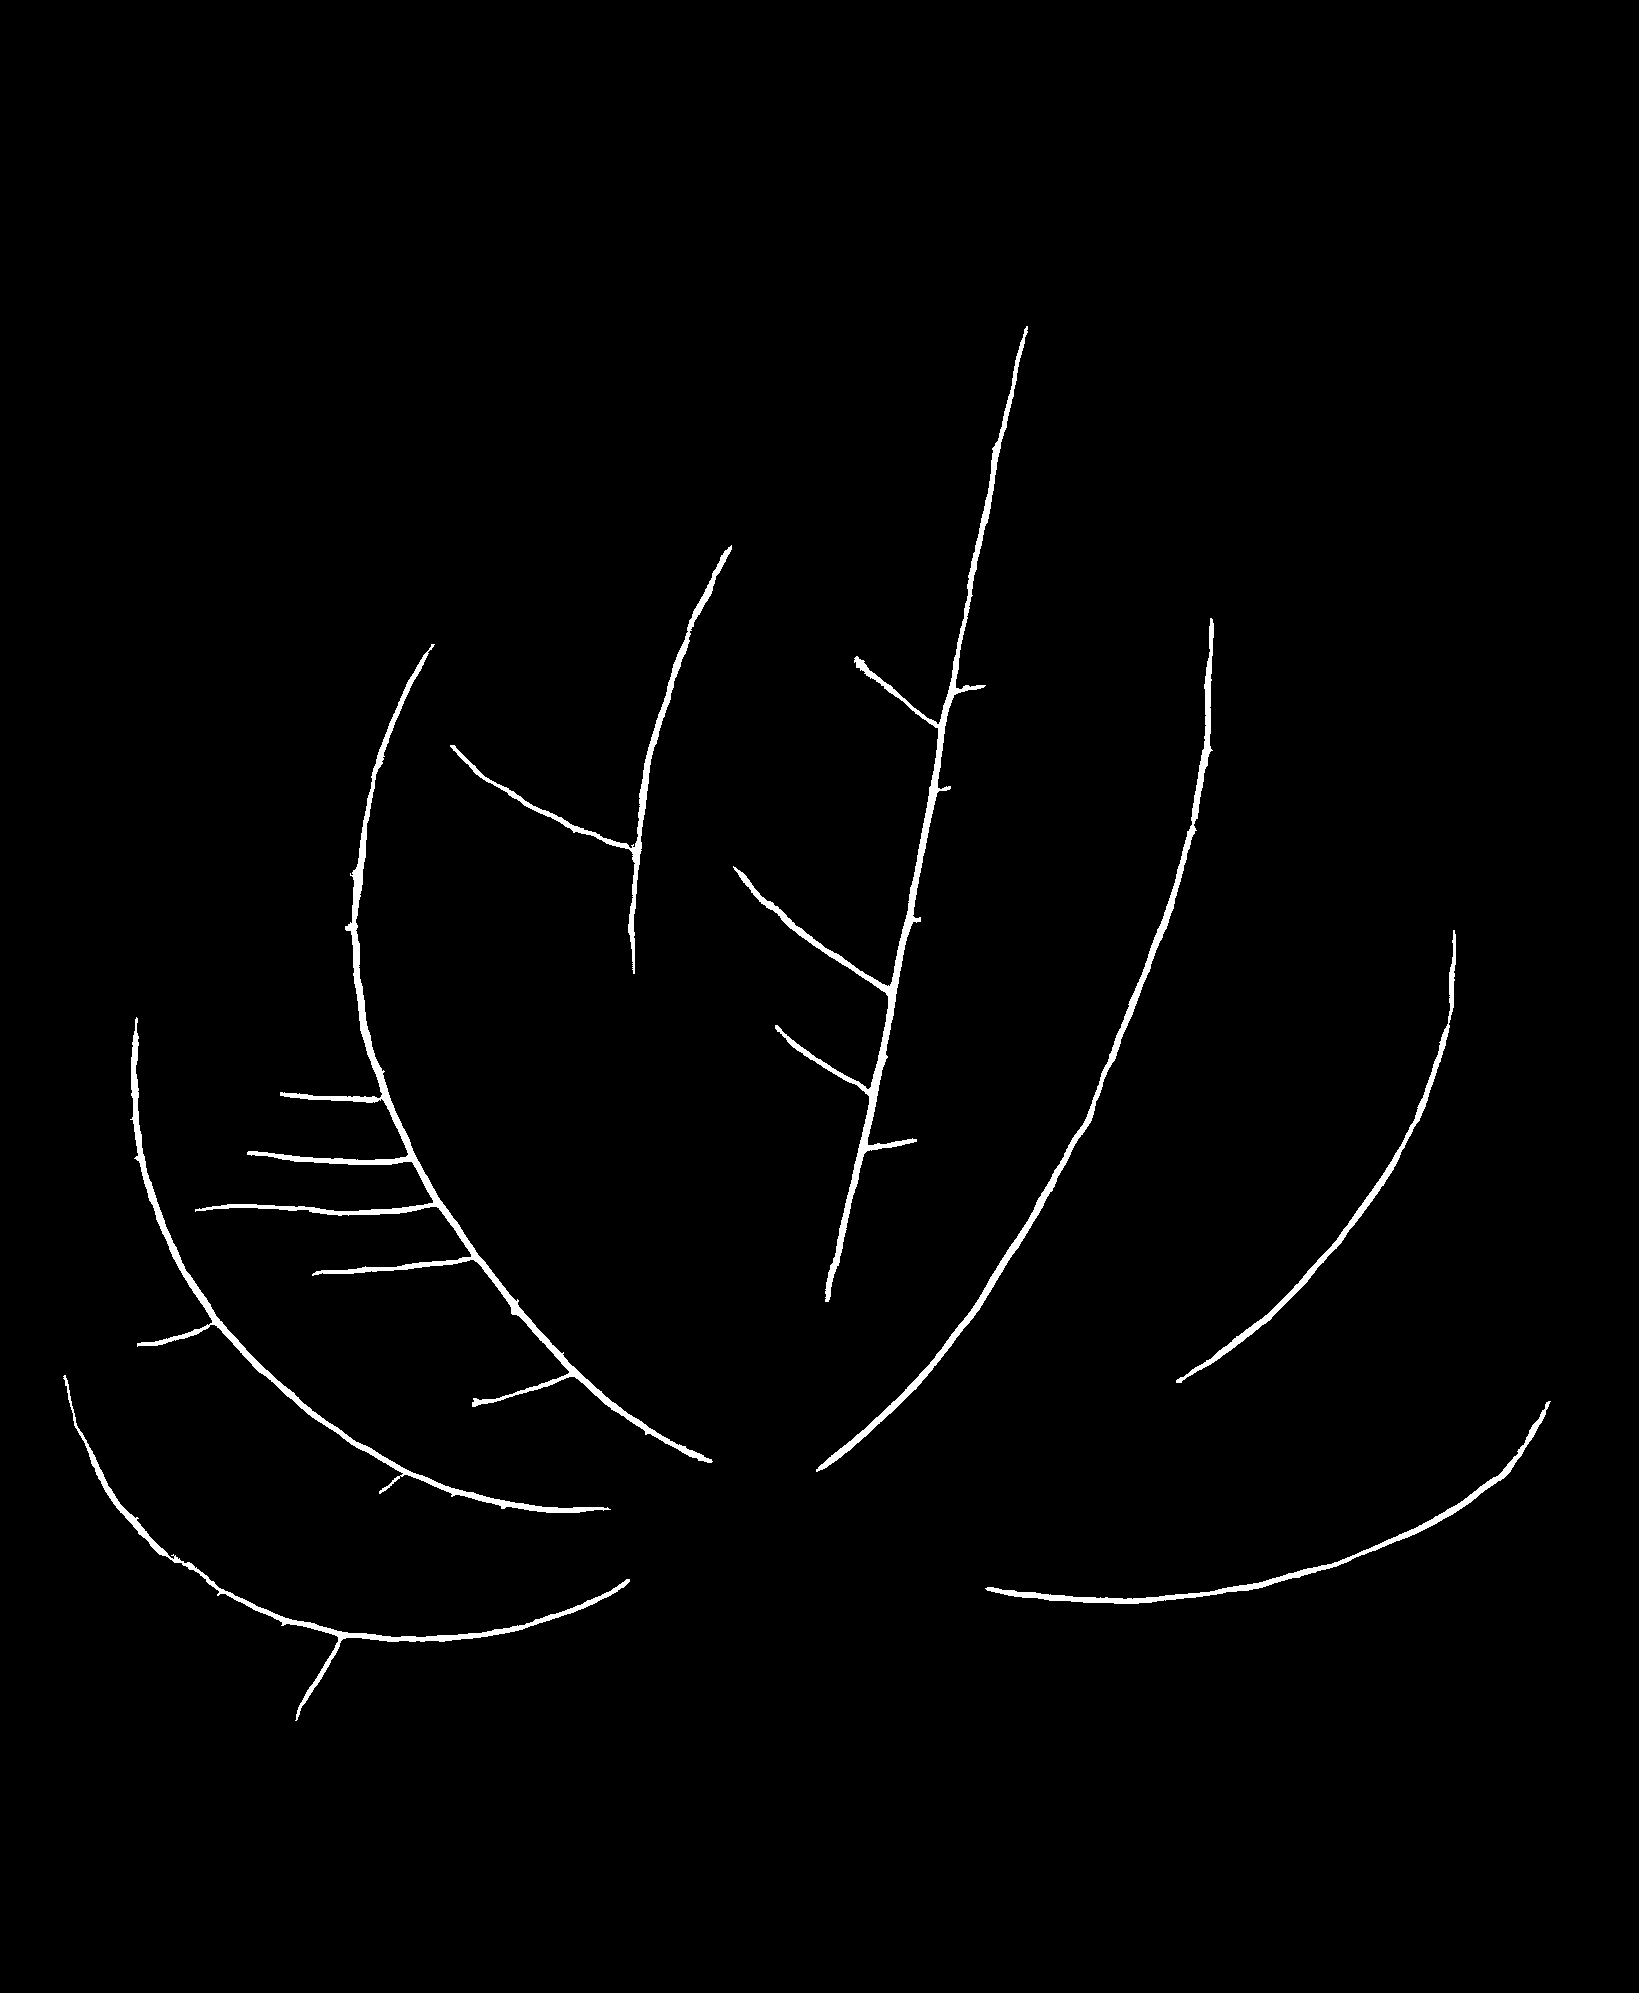

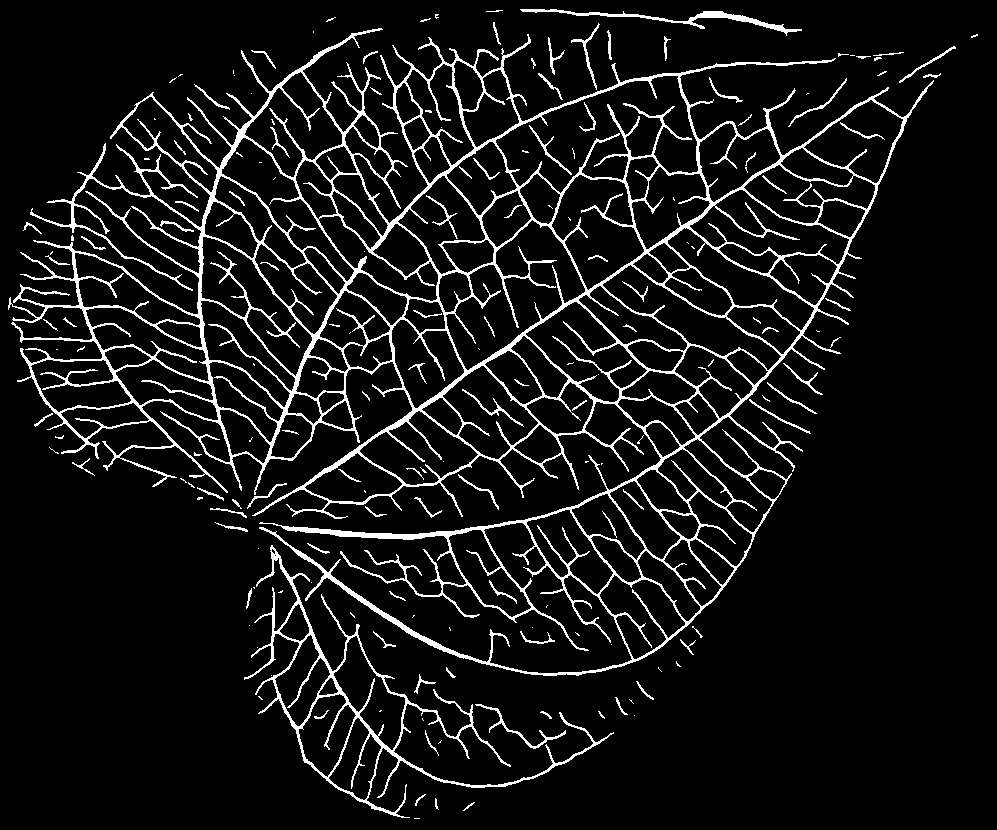

1.8242782074048378
1.850273158249574
1.886246229918736
1.9144021257768387


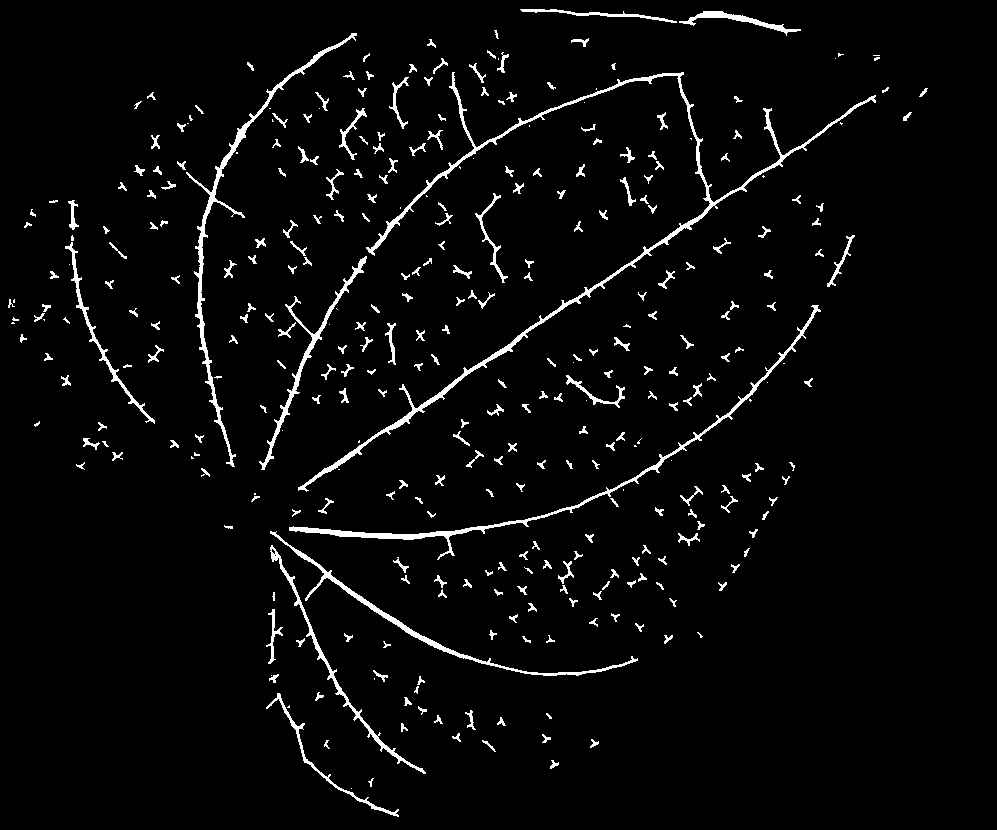

827510


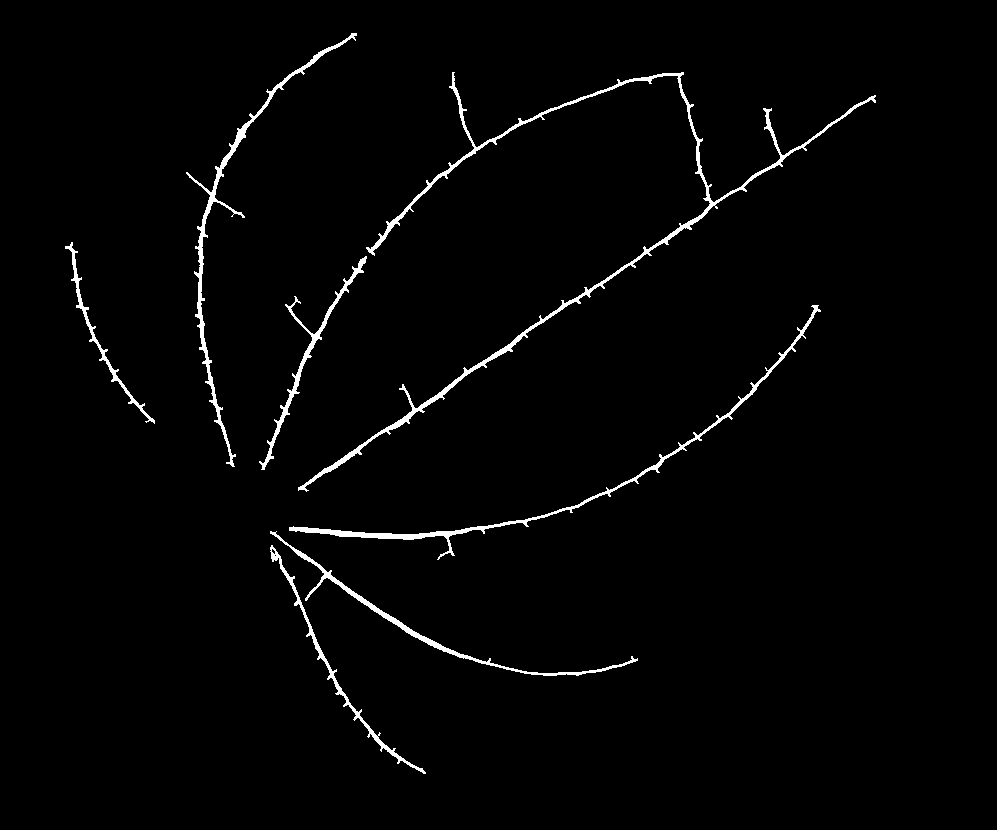

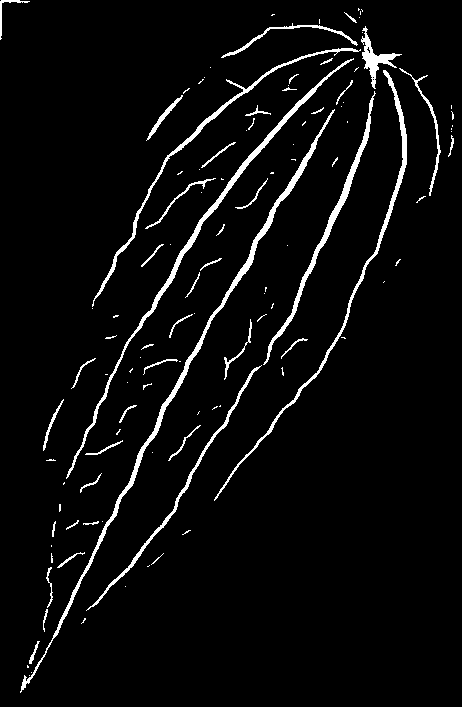

2.526469963230167
2.5564554900947947
2.5564554900947947
2.5564554900947947


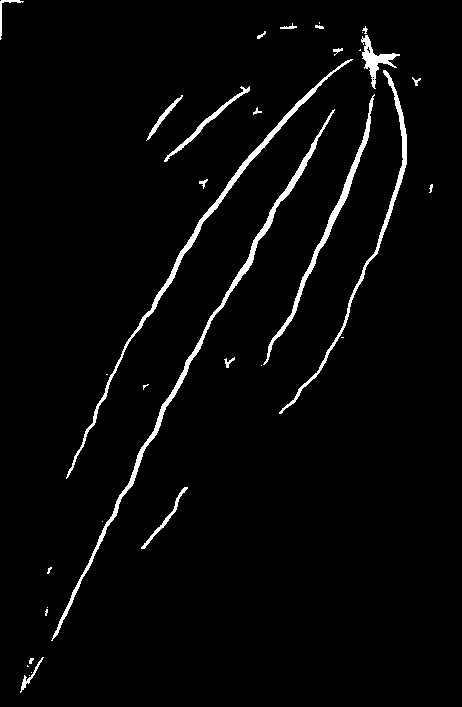

326634


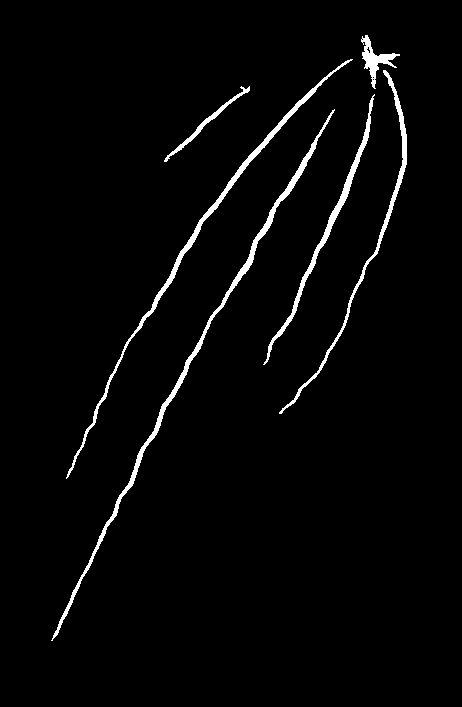

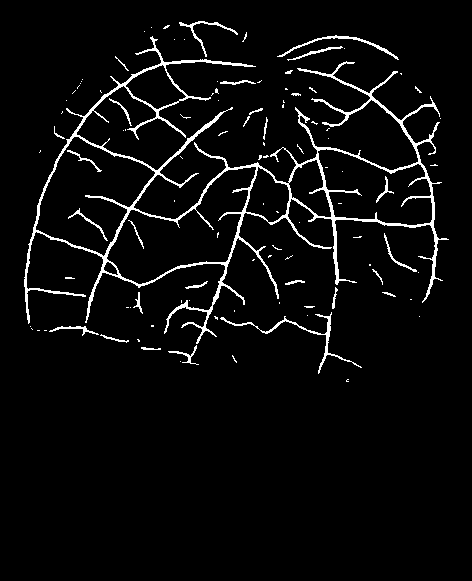

1.6356611583663097
1.6843135304424646
1.7240326112950293
1.7481763709319484


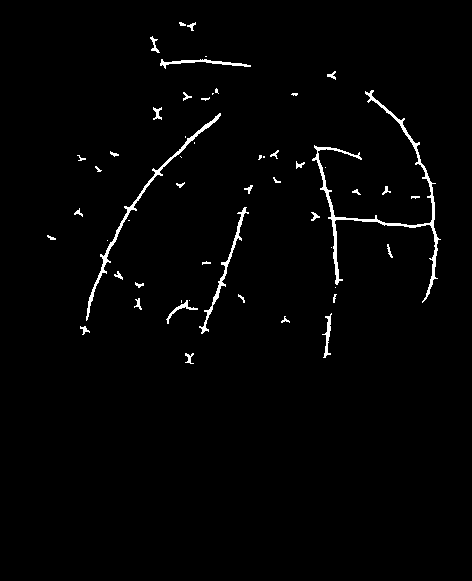

274232


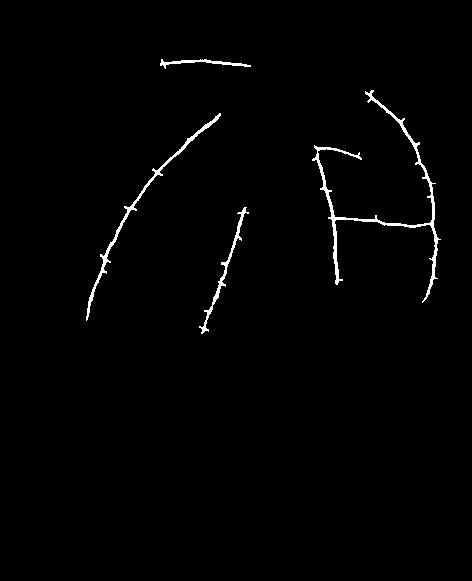

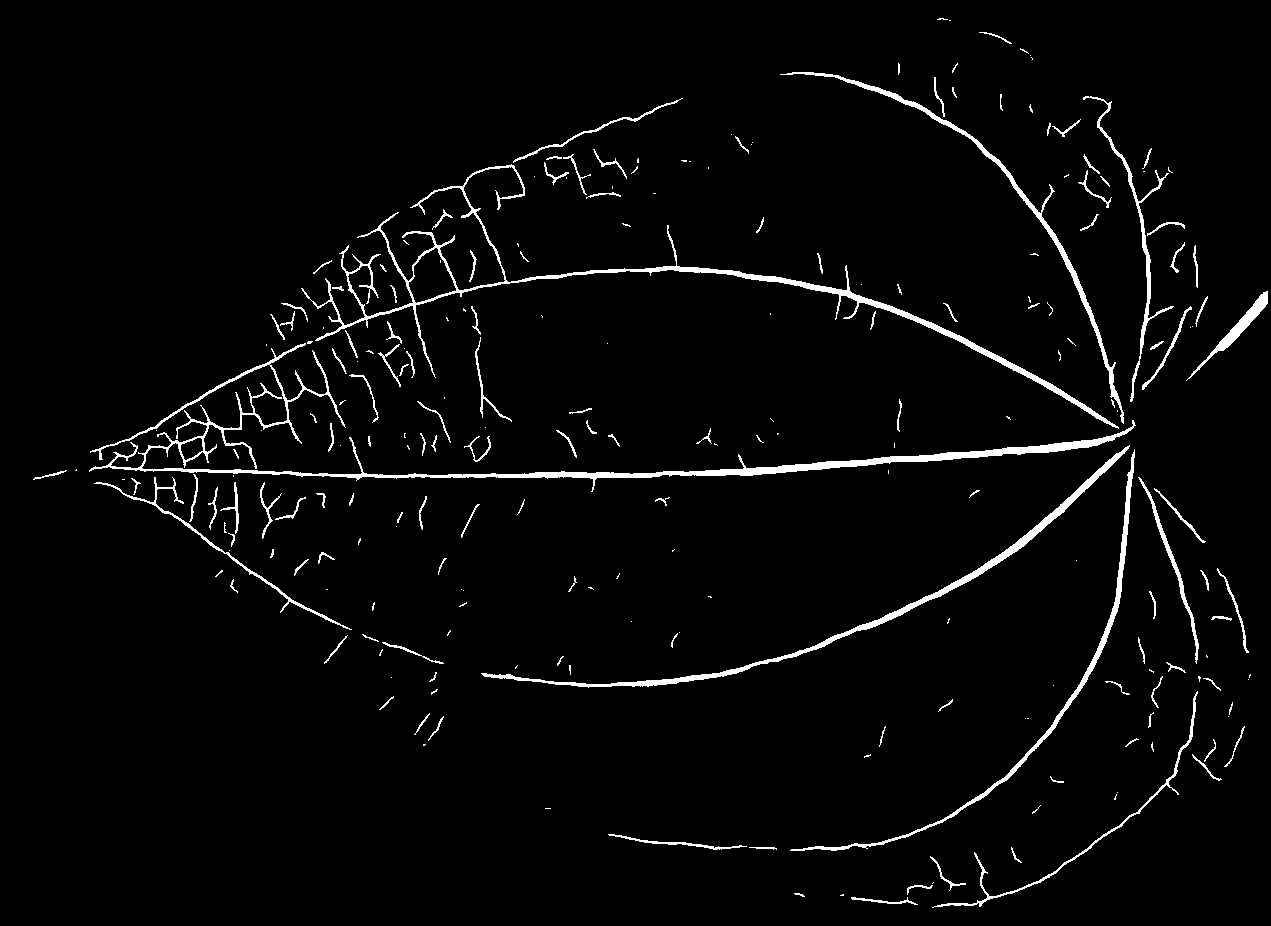

1.8817755307420392
1.887853627584881
1.887853627584881
1.887853627584881


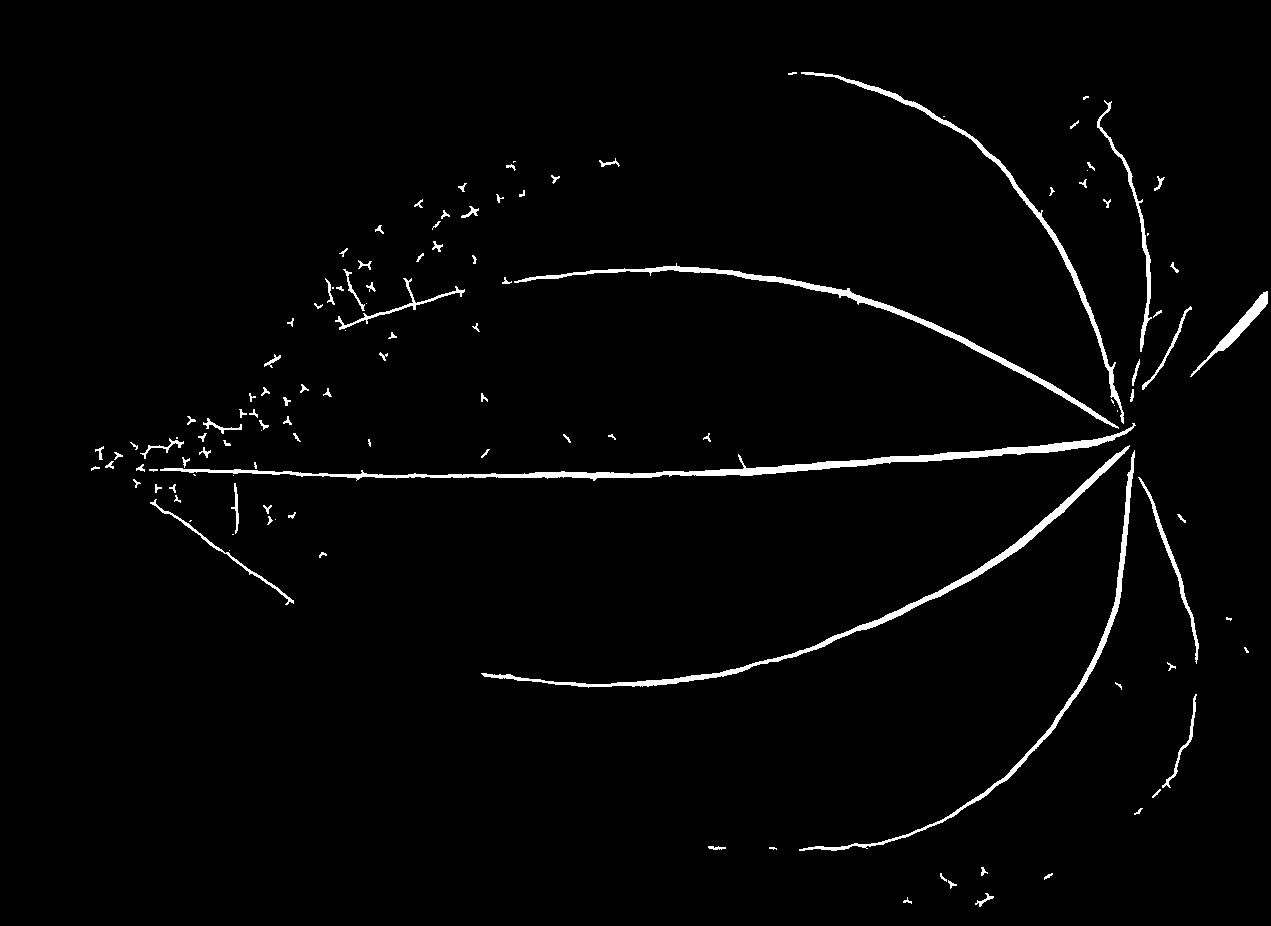

1176946


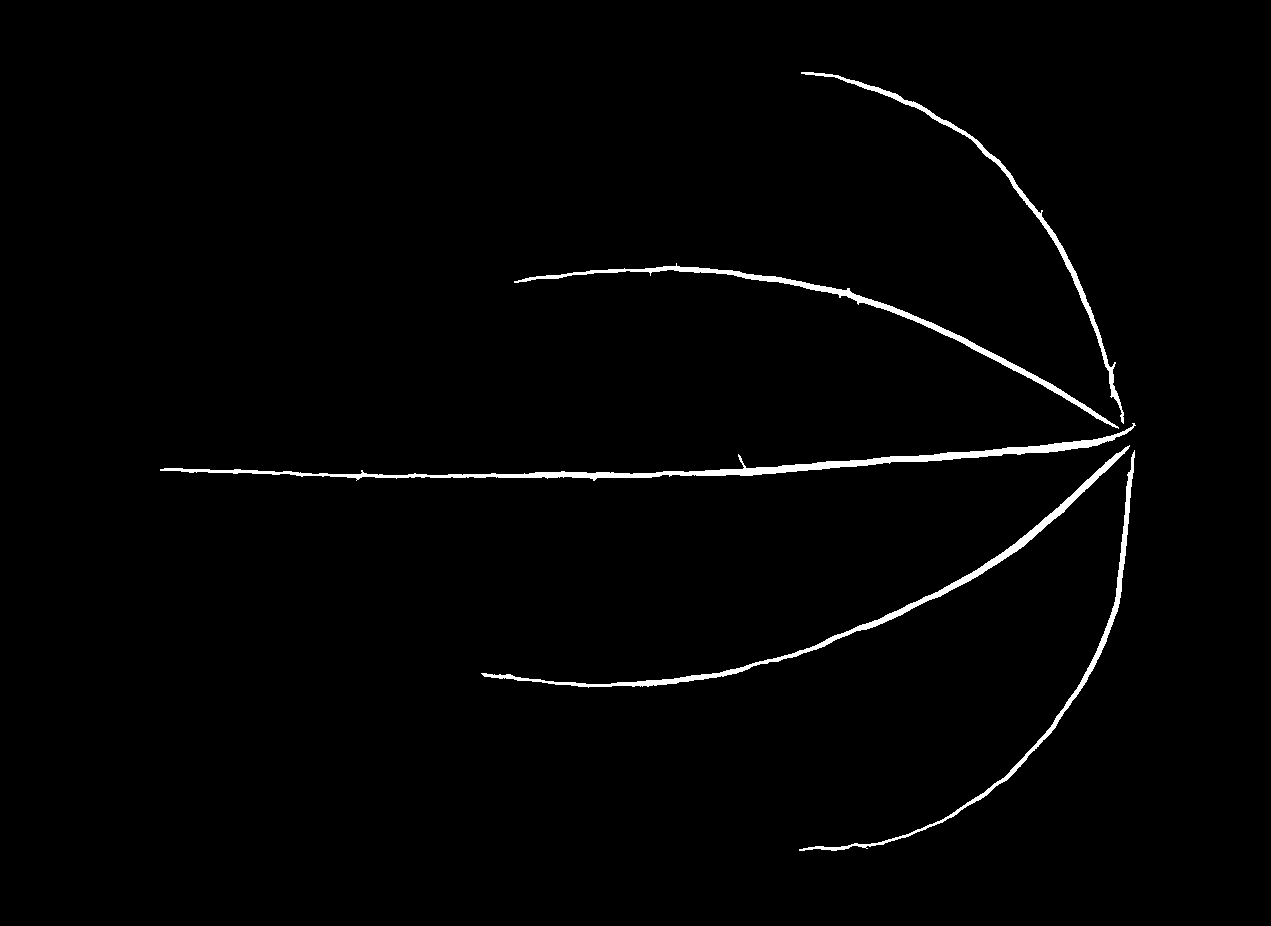

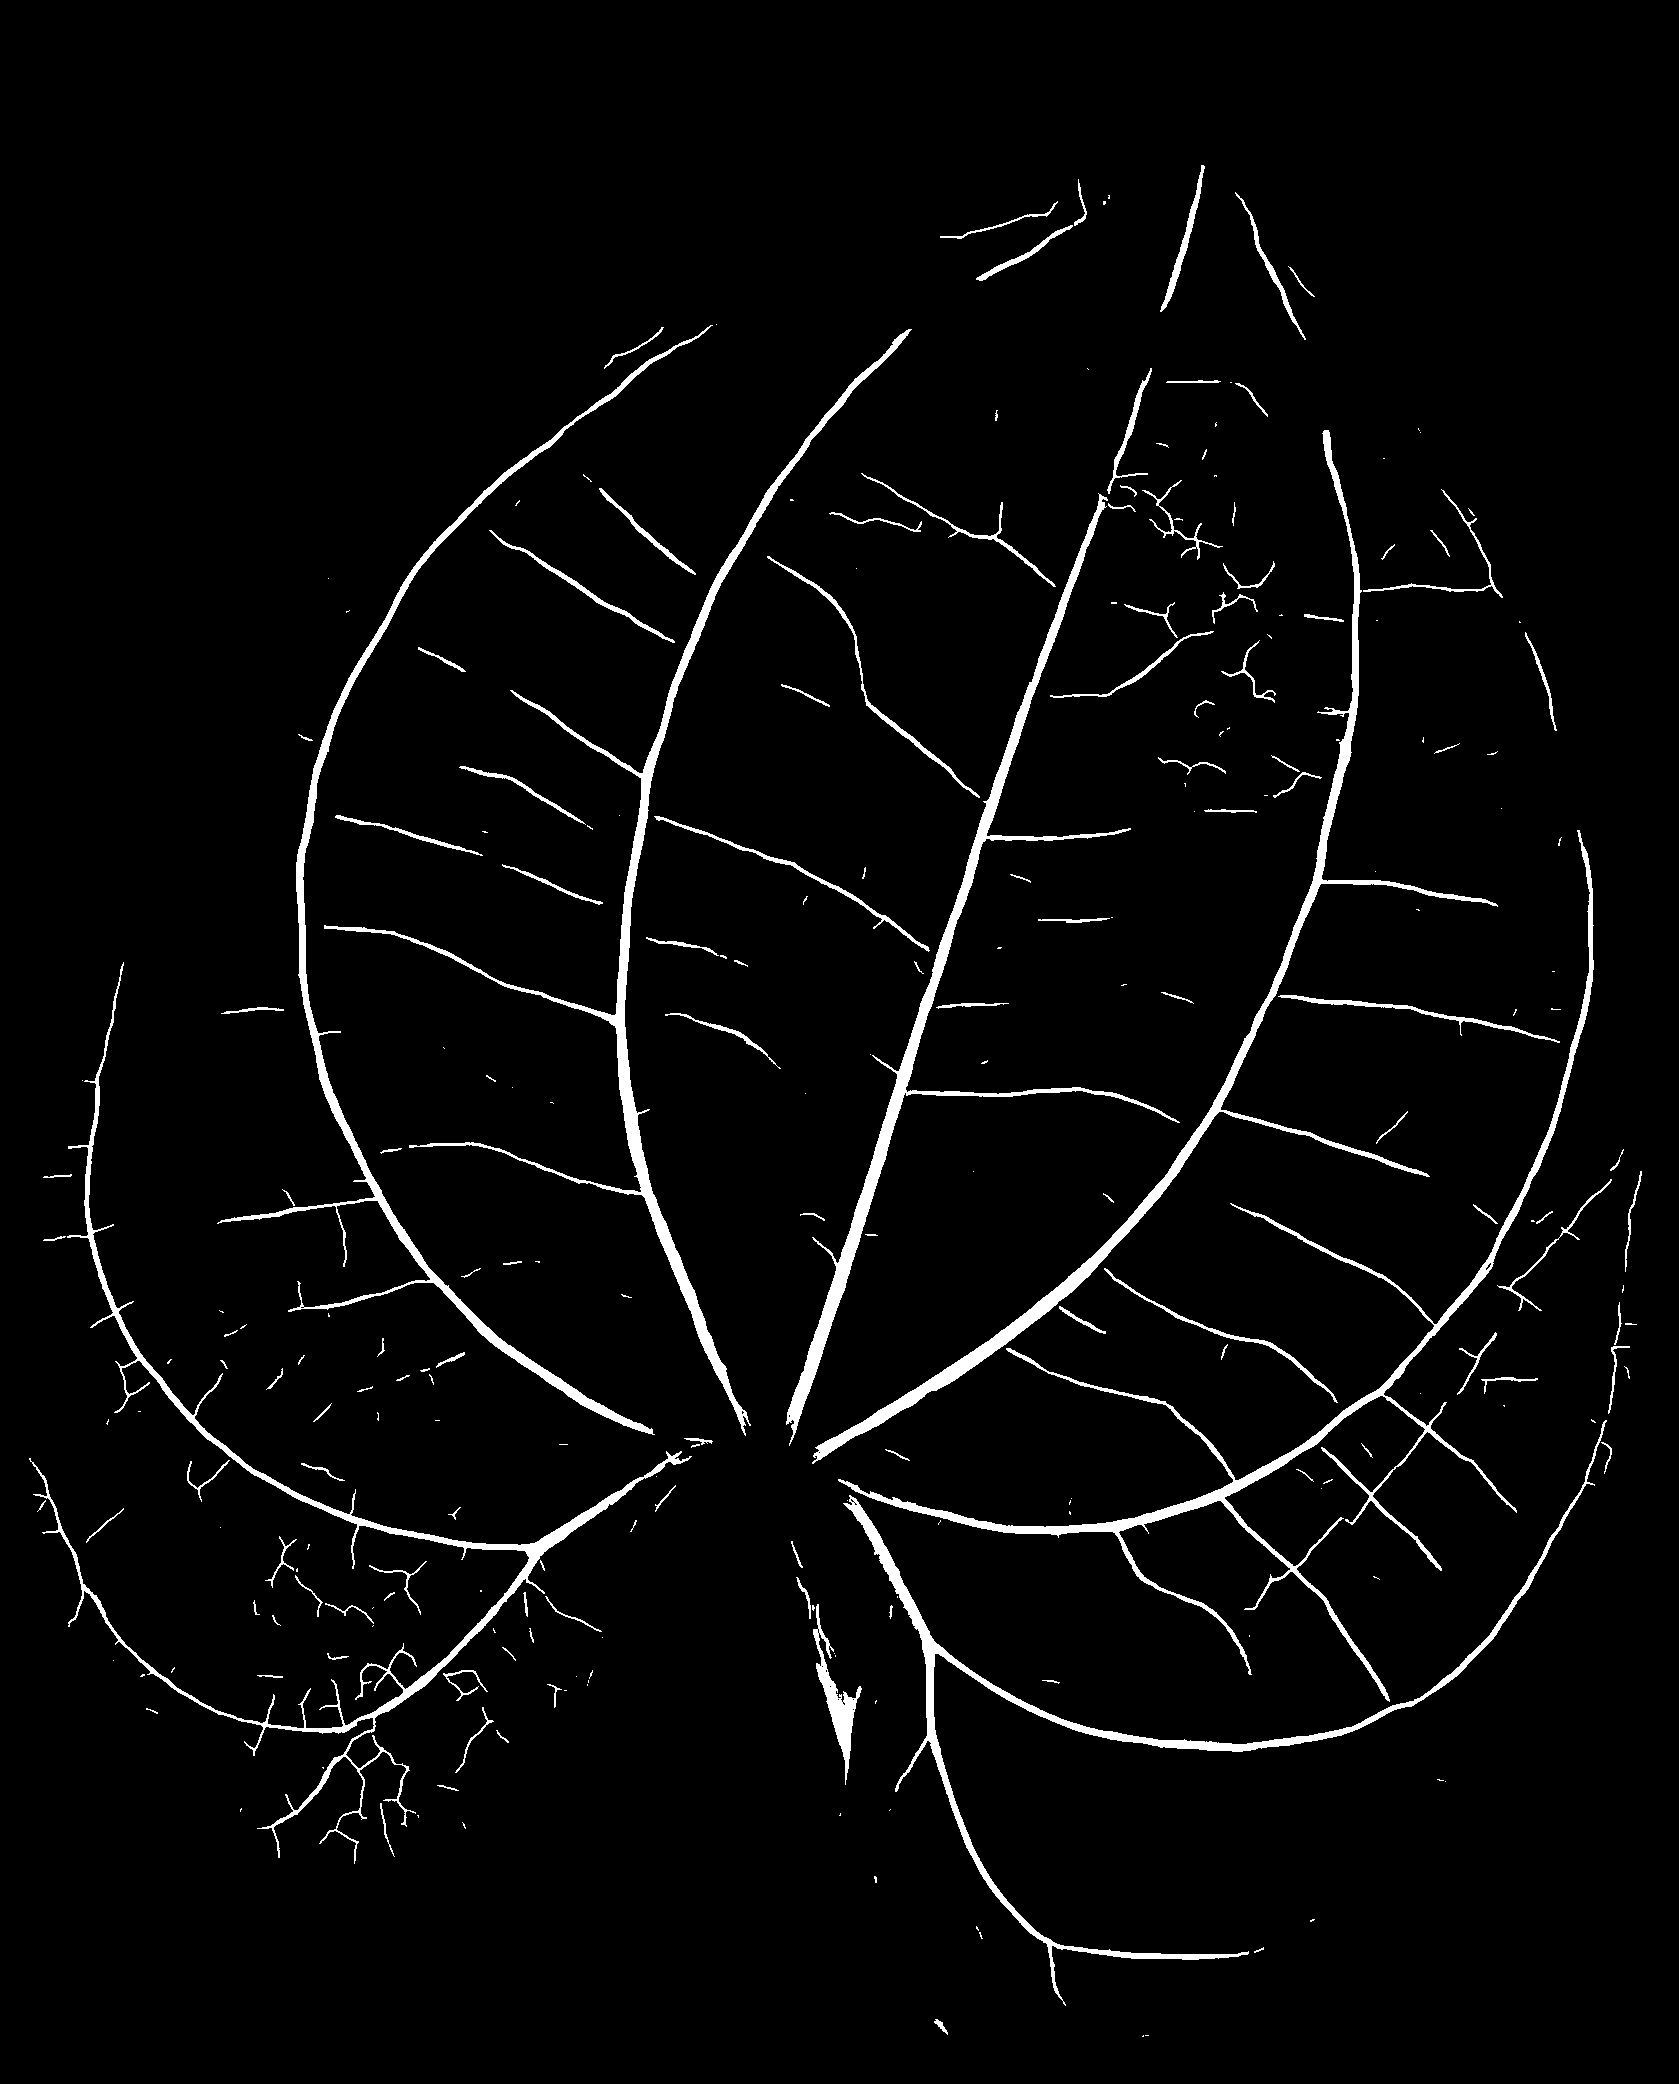

3.8173338285152583
4.019532276832534
4.331101969729881
4.465670502587216


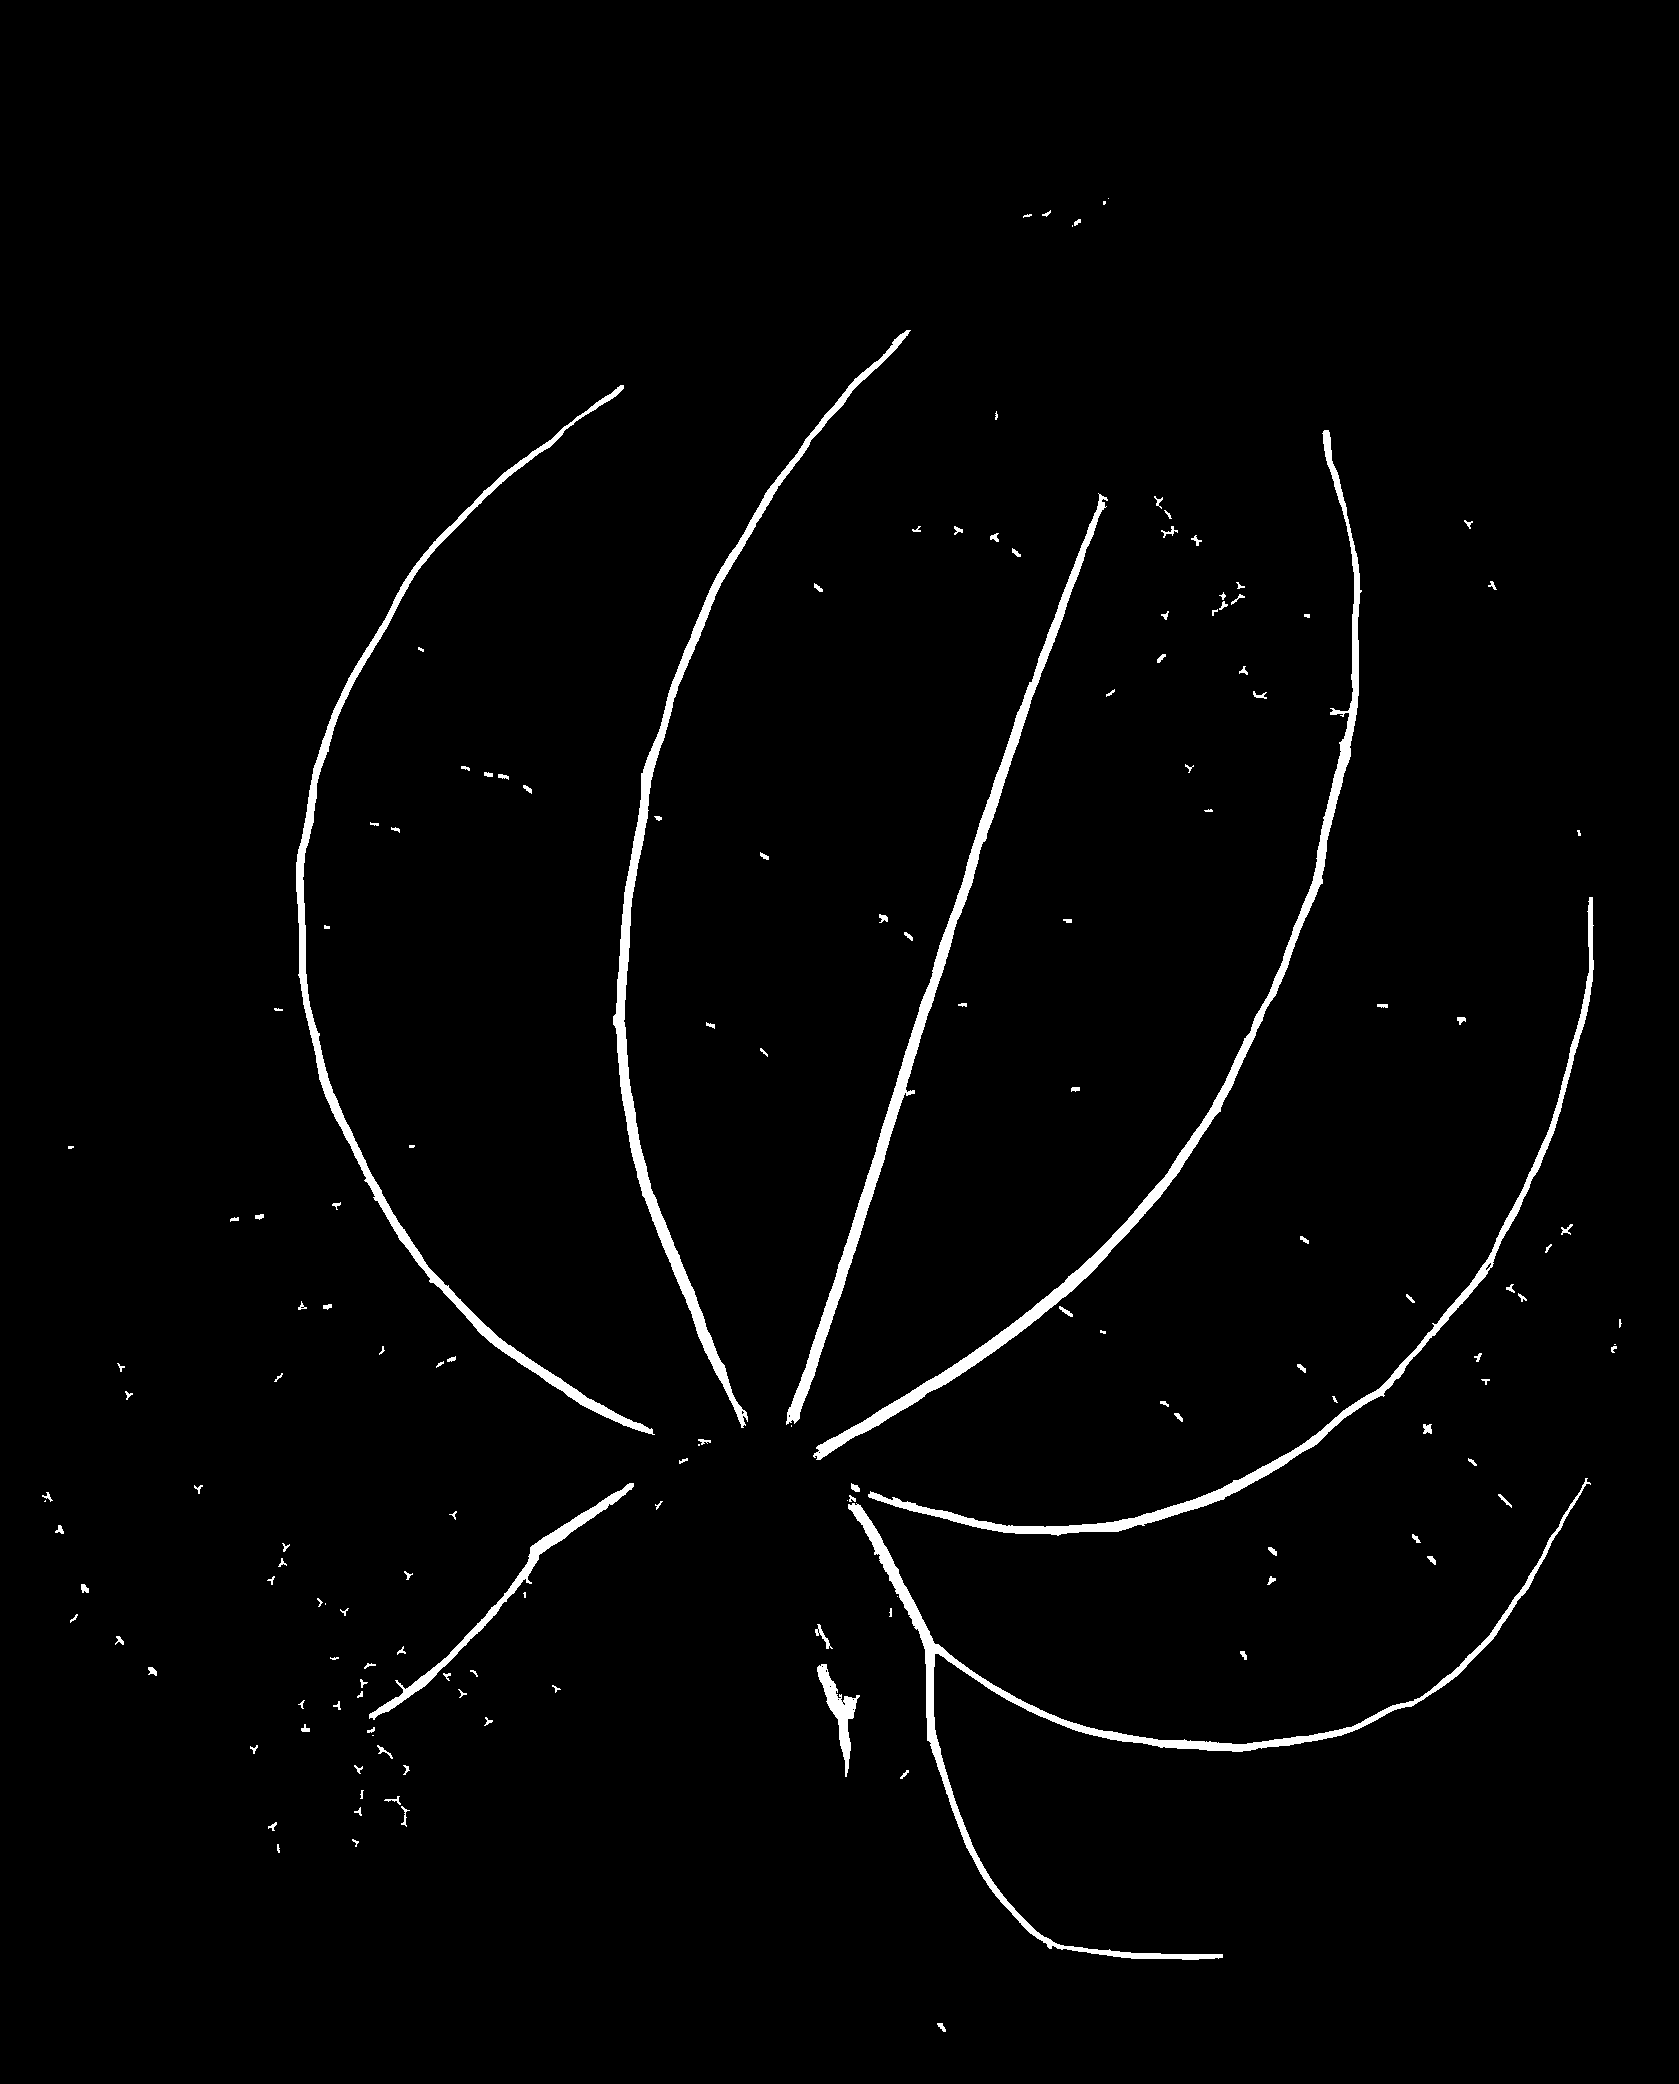

3499036


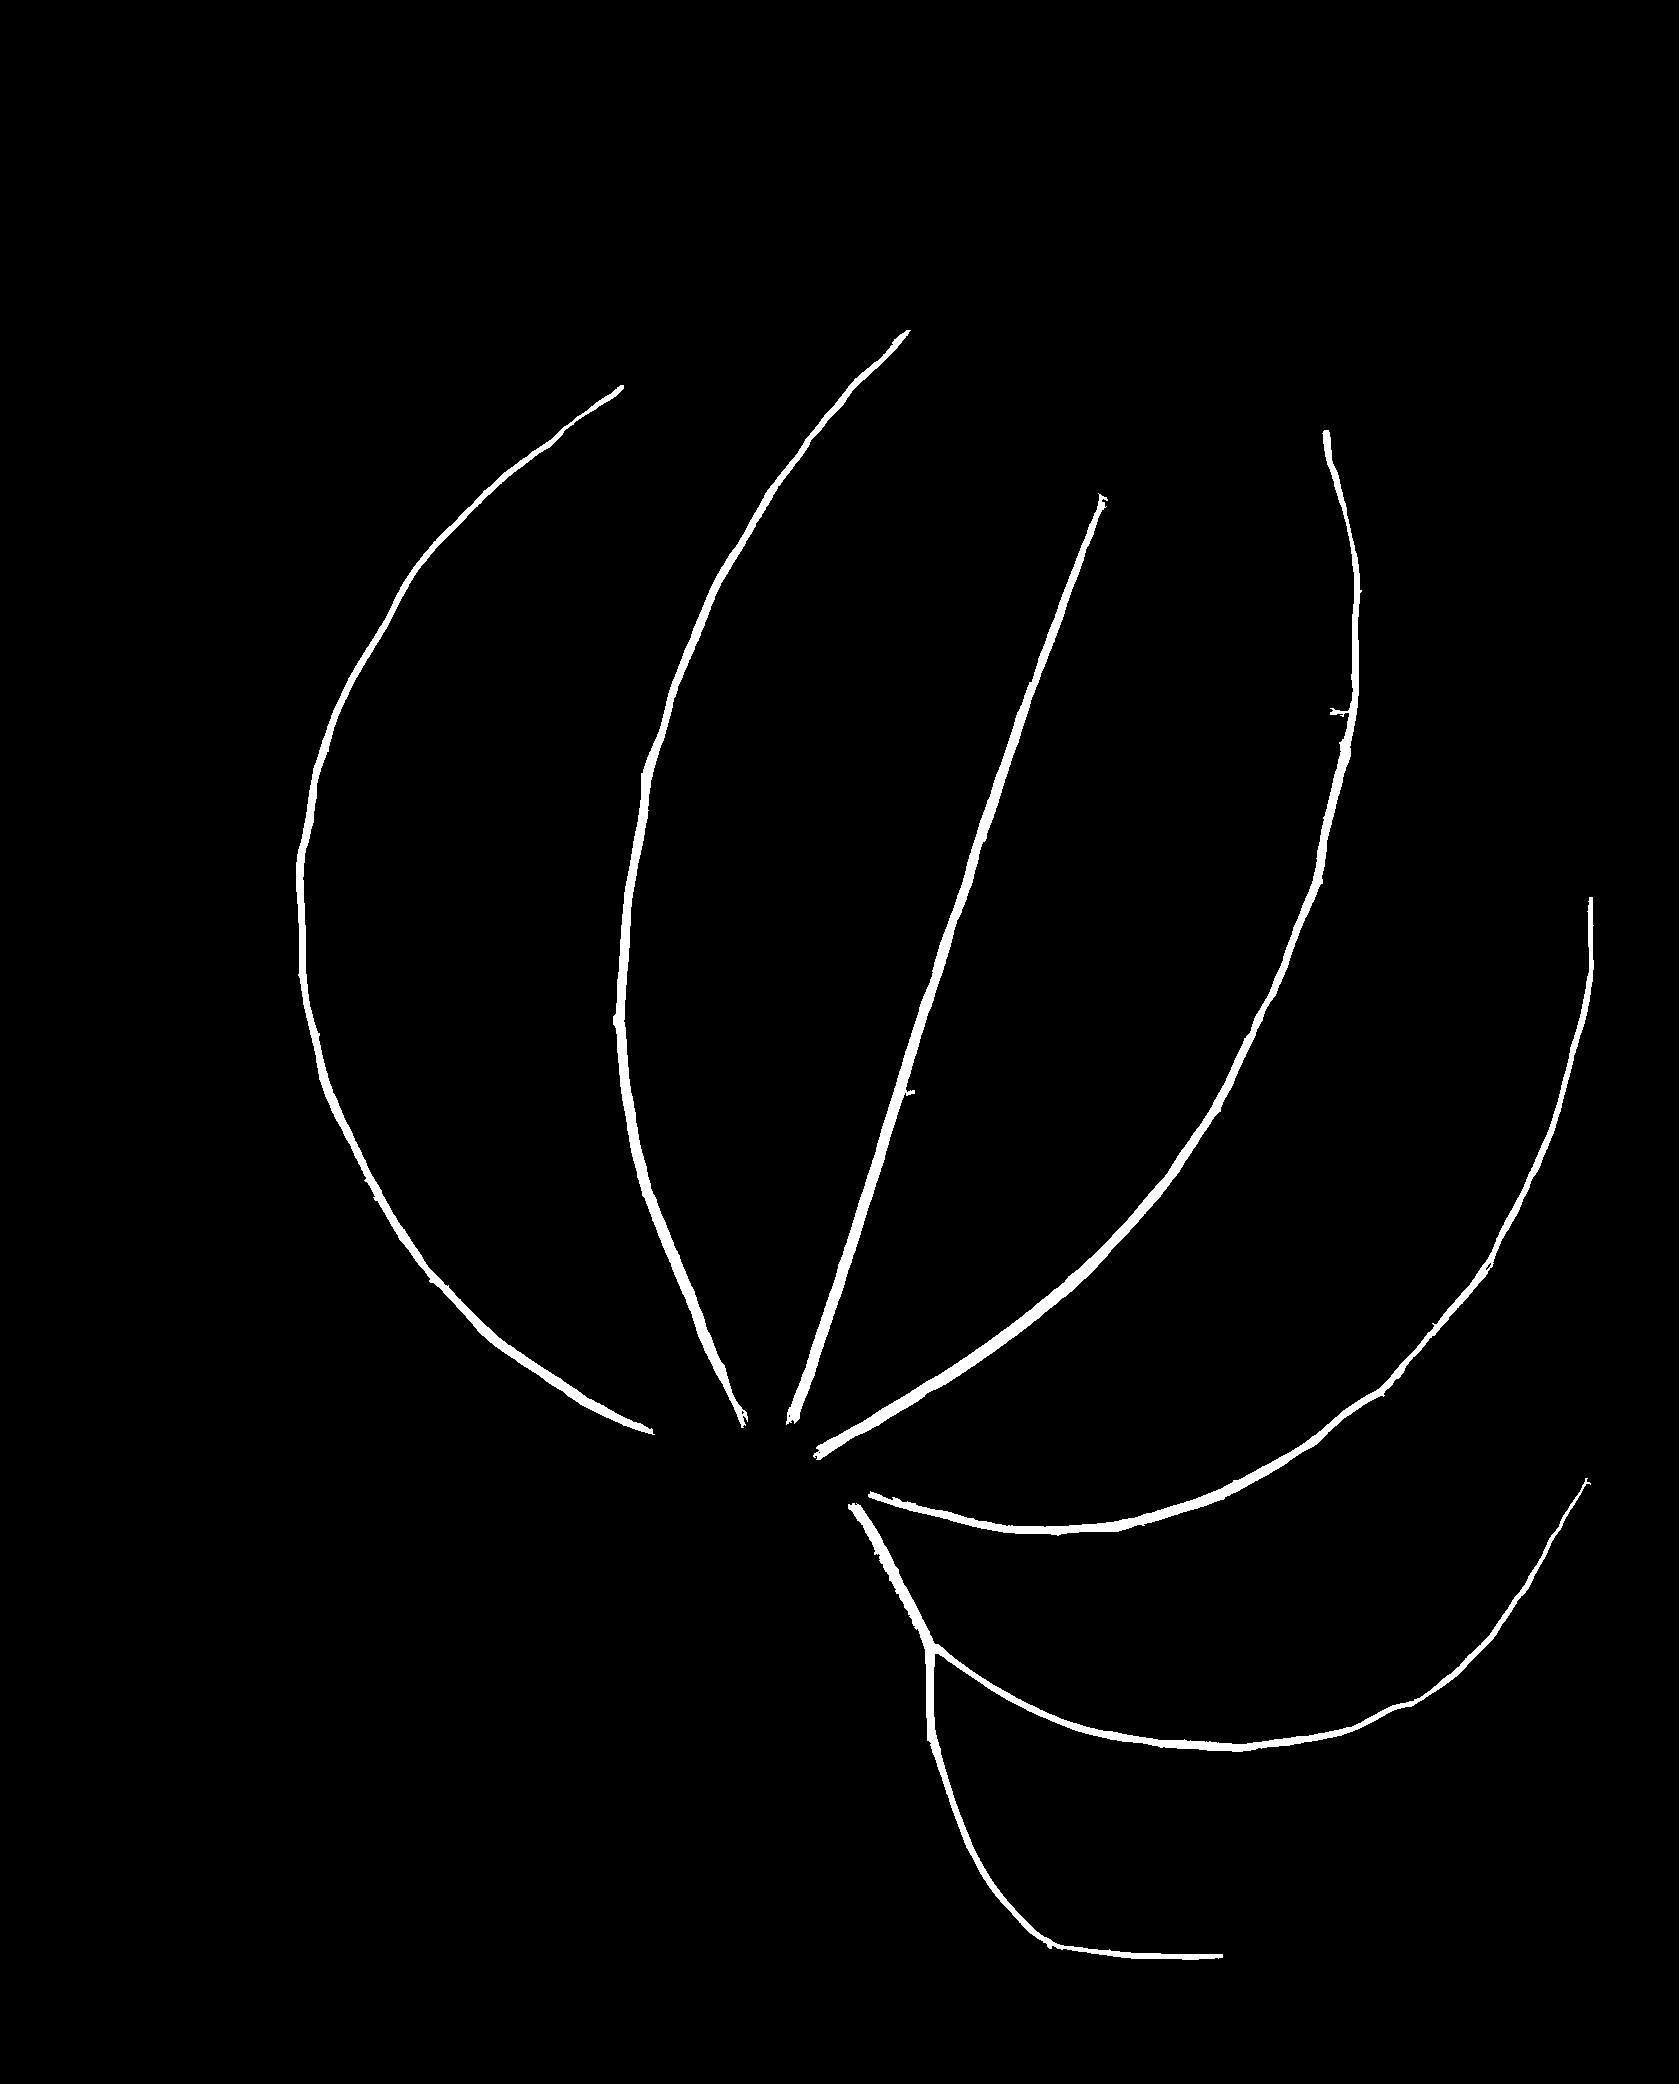

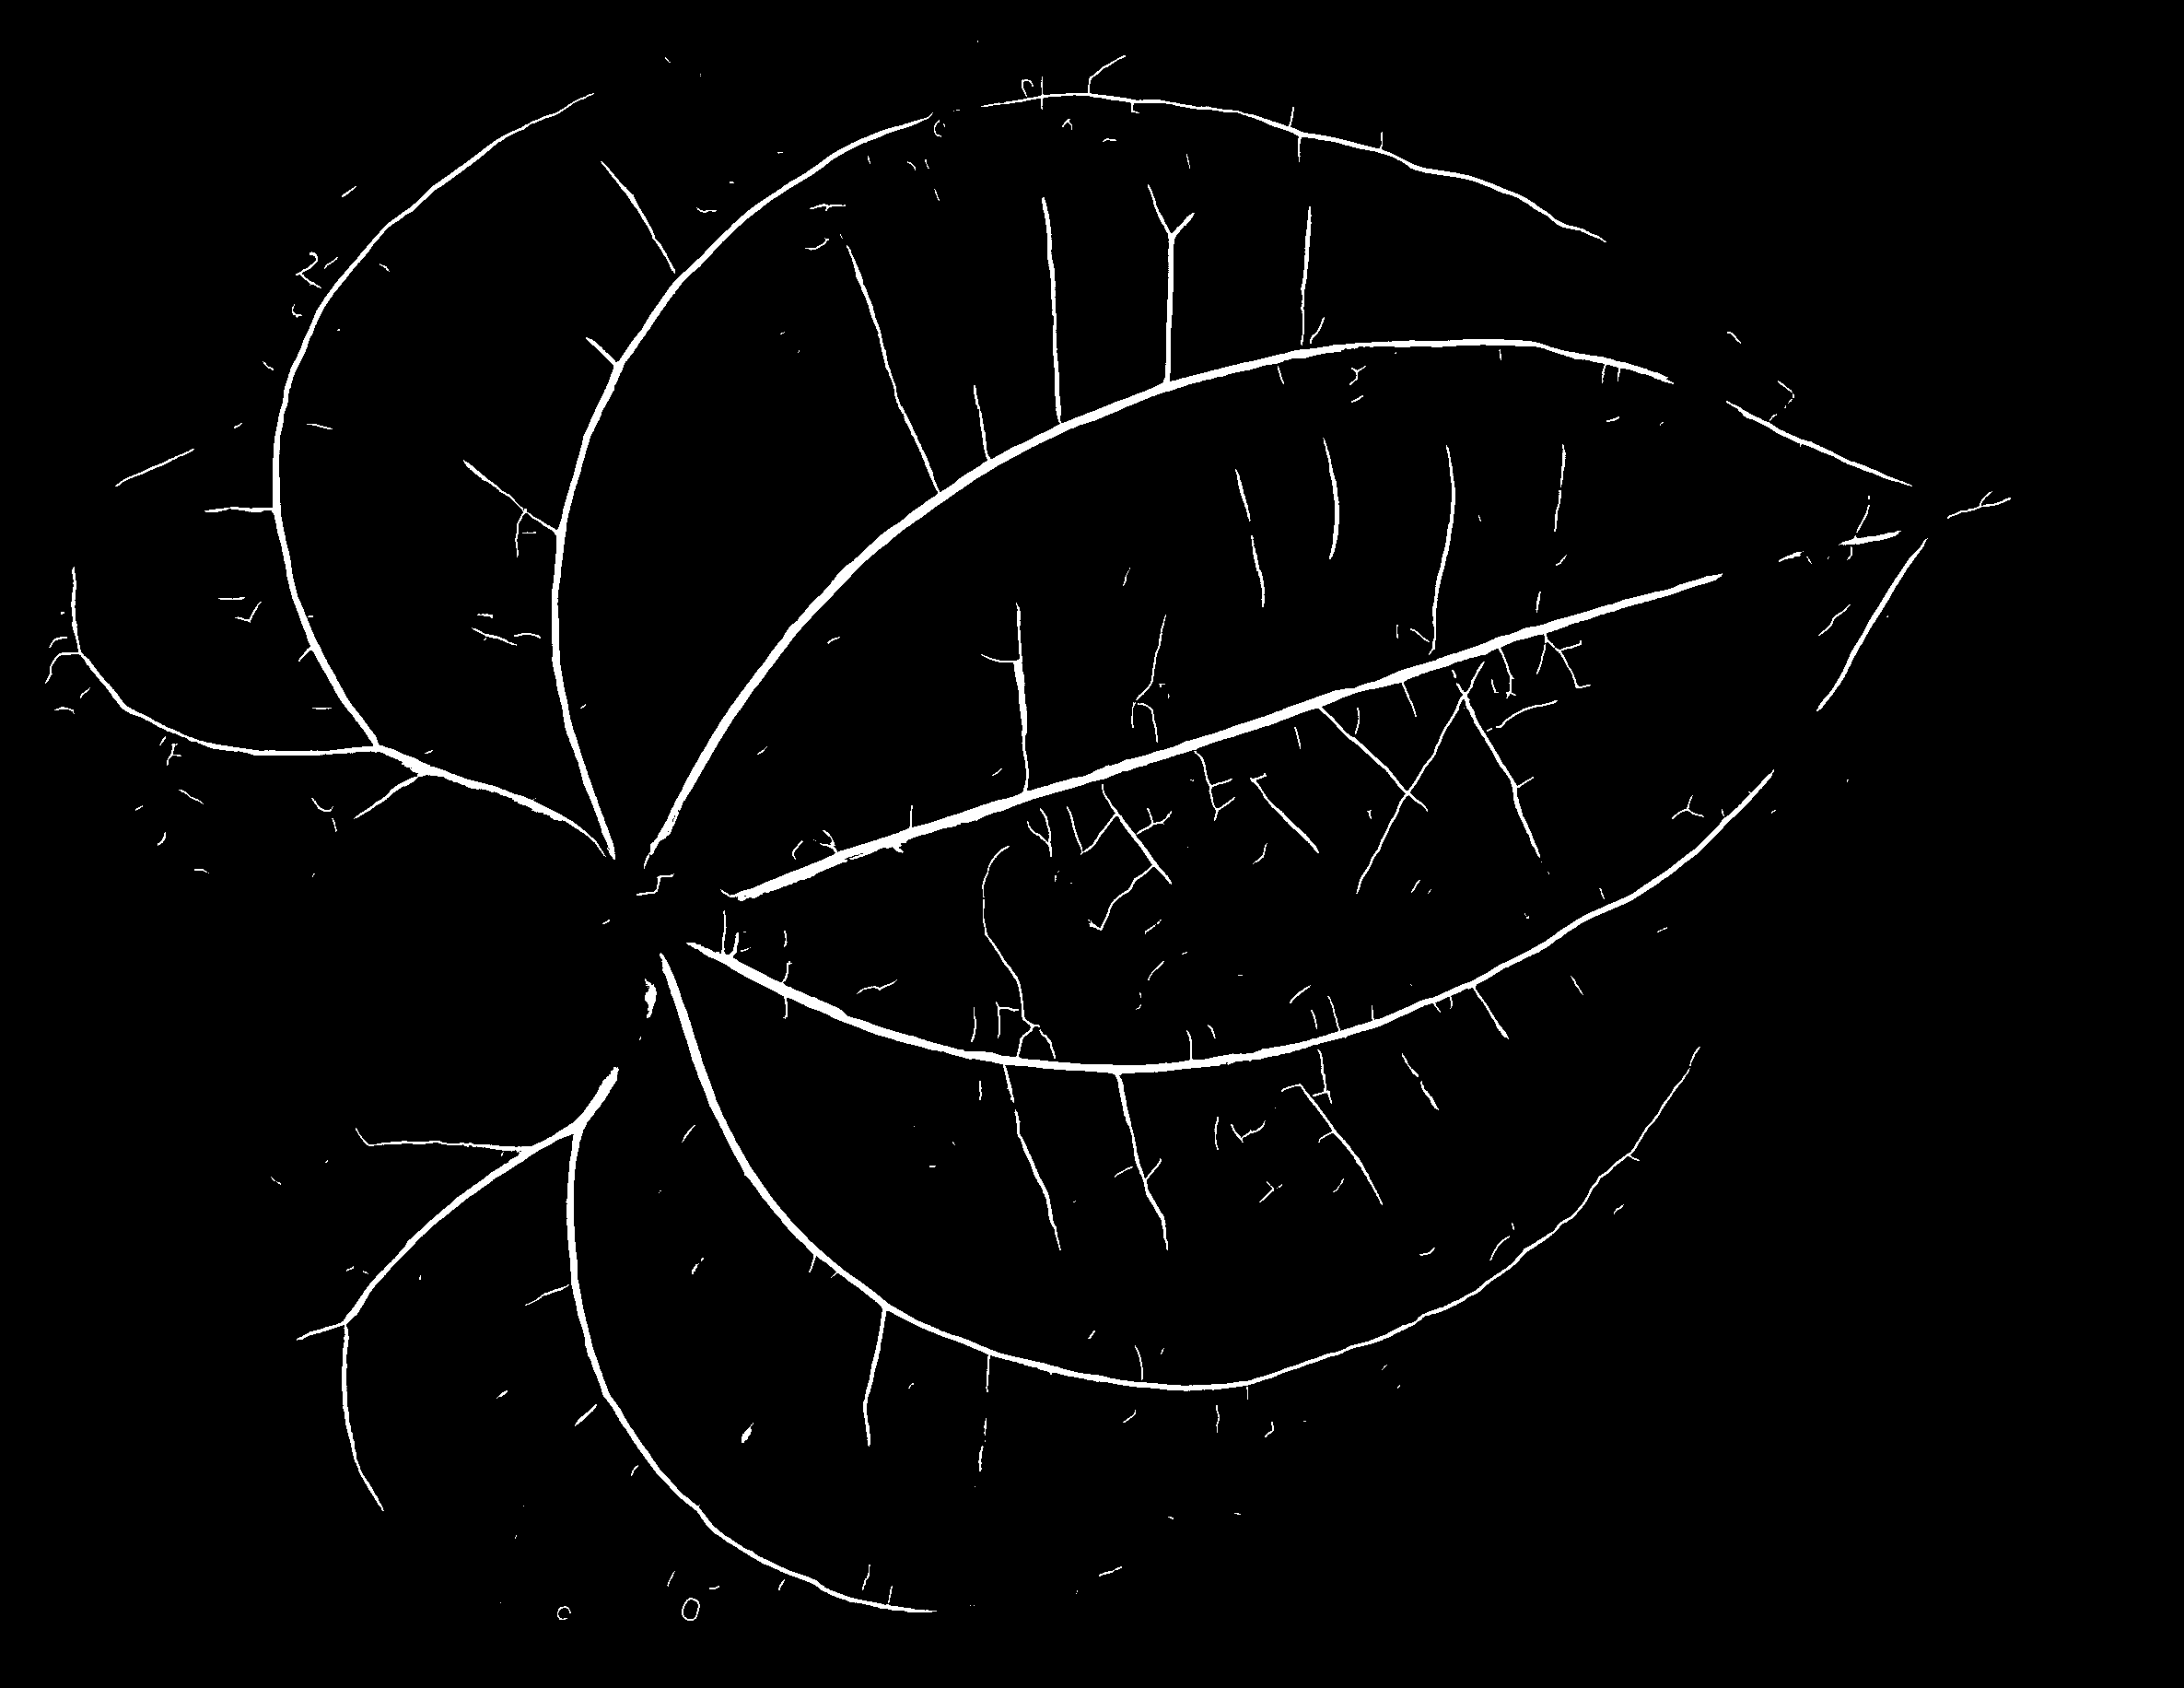

3.5241551116643803
3.6404647013076654
3.807932807844834
3.9633550839208542


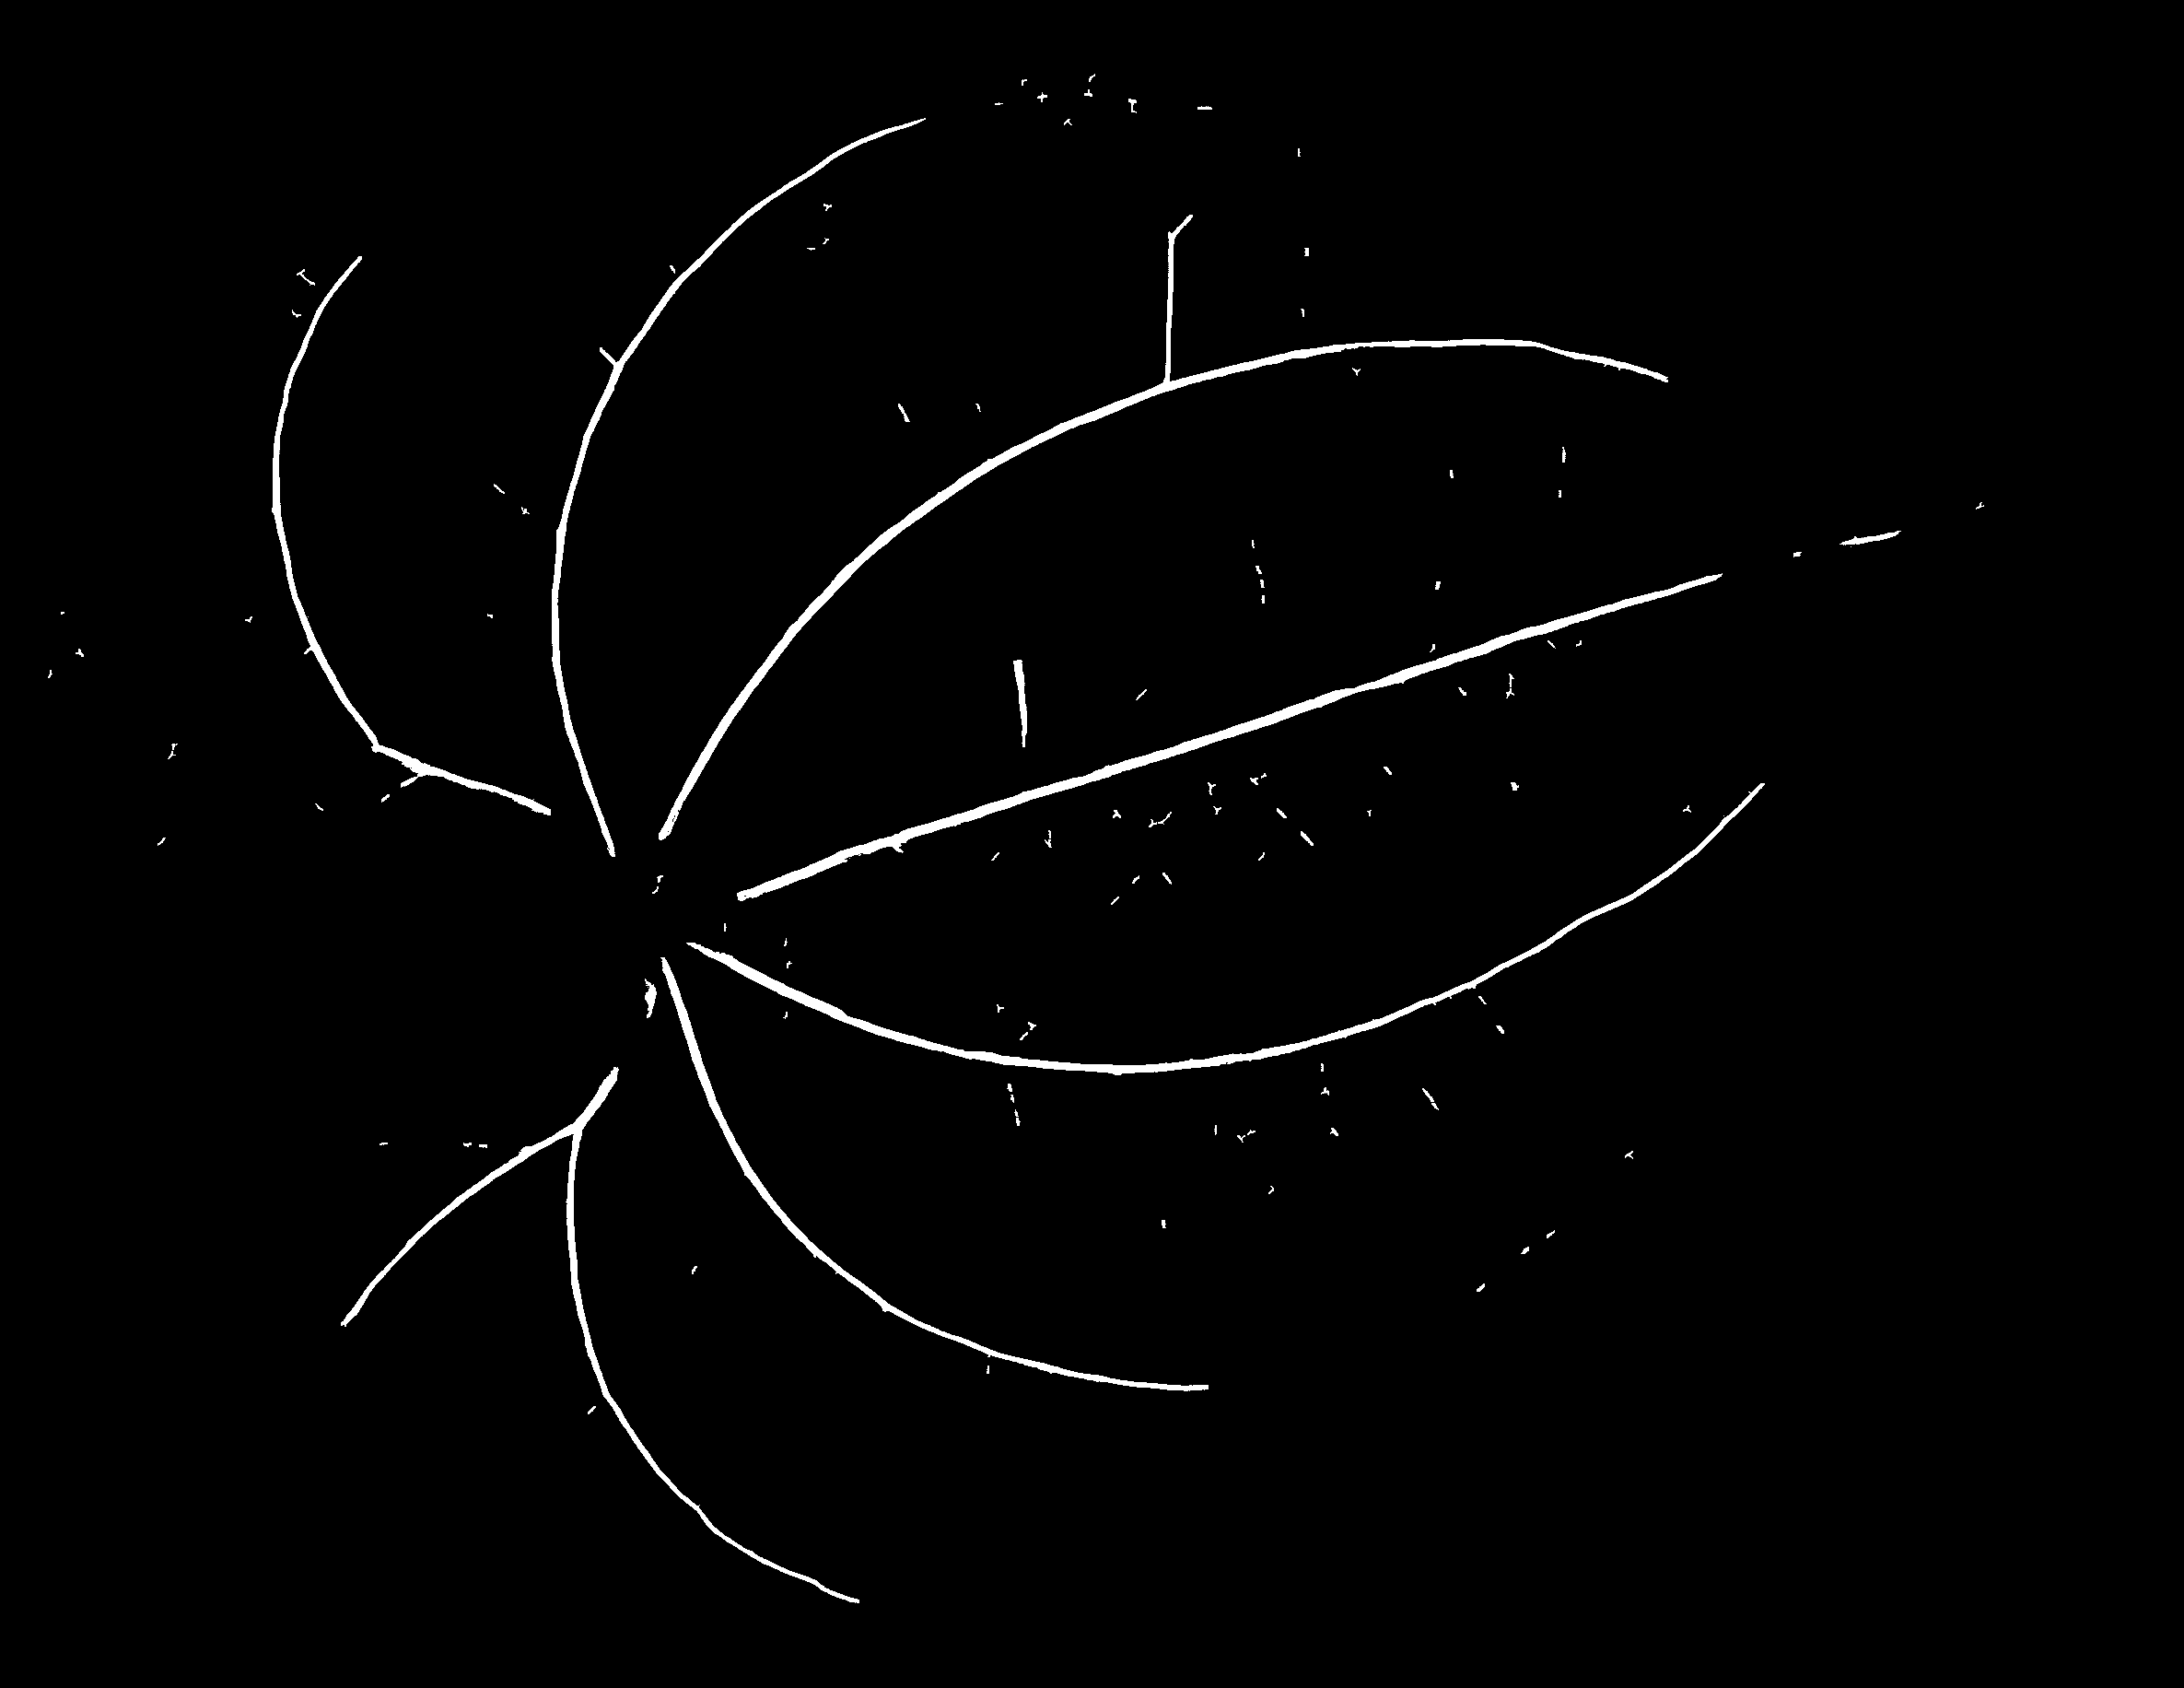

4343672


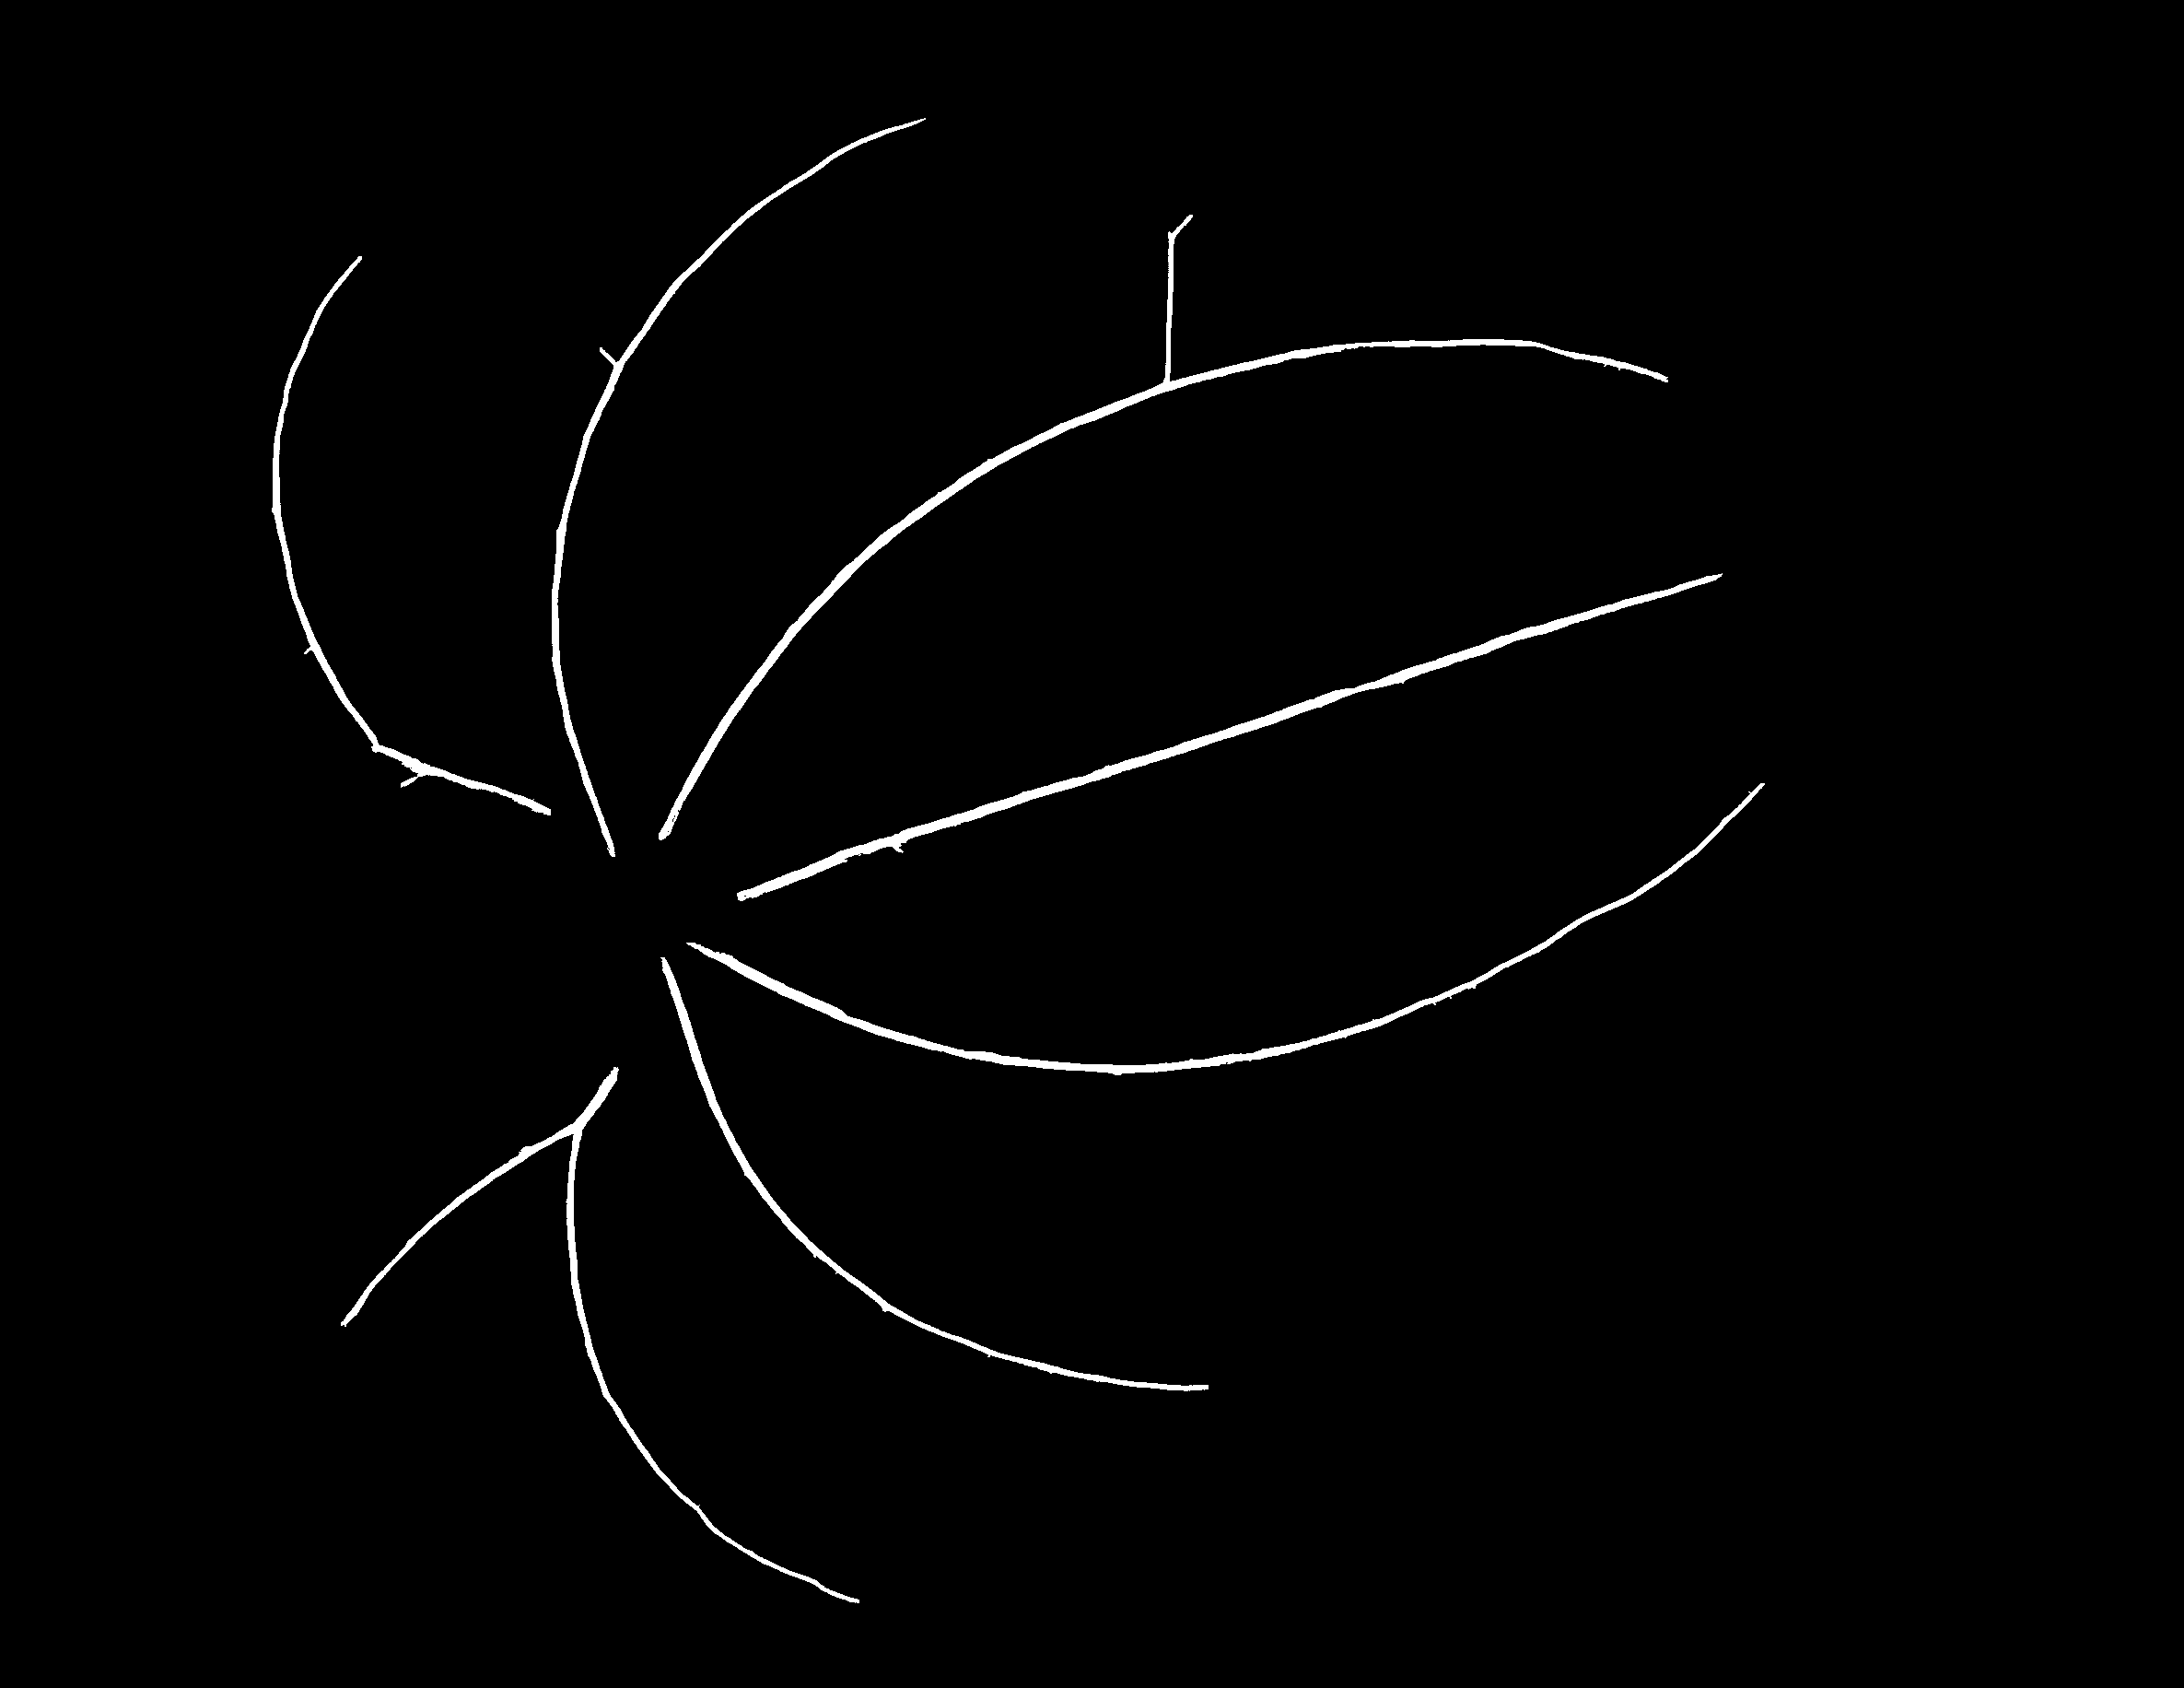

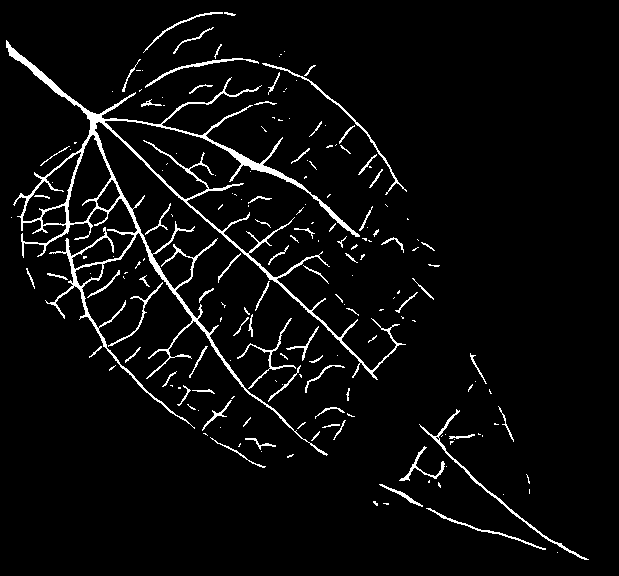

1.9759015457558189
1.9759015457558189
1.9759015457558189
1.9759015457558189


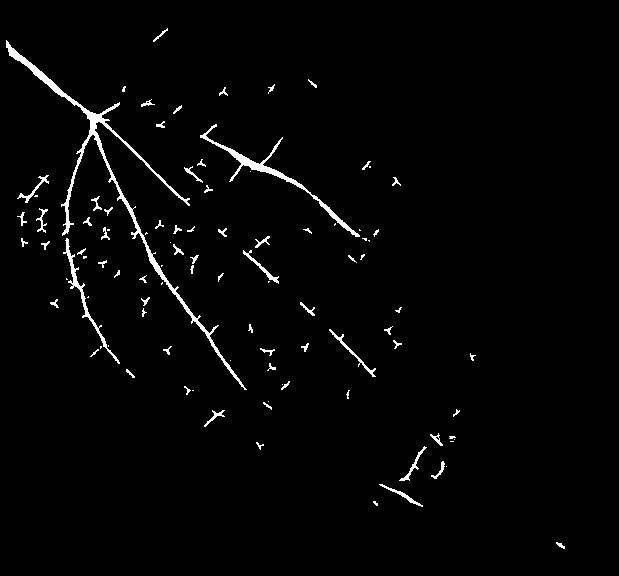

356544


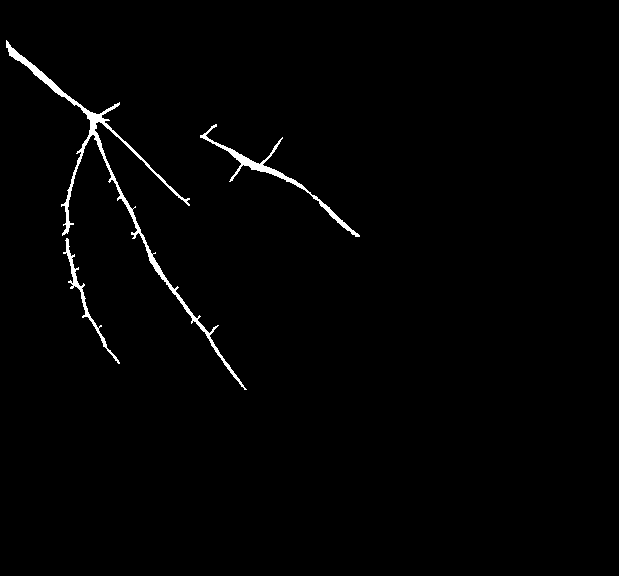

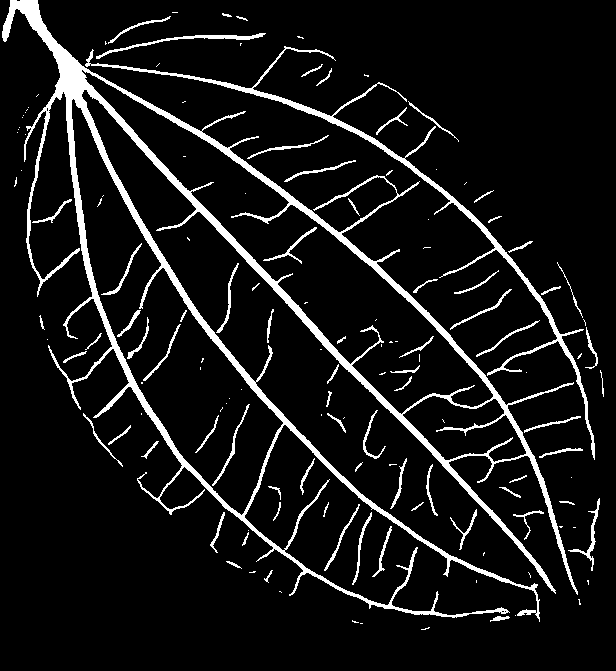

4.918904196768622
5.028074708991624
5.134986063809552
5.134986063809552


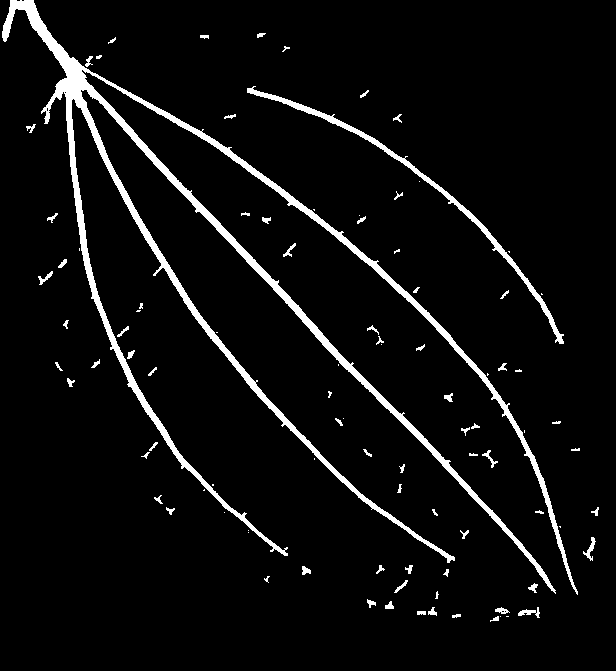

413336


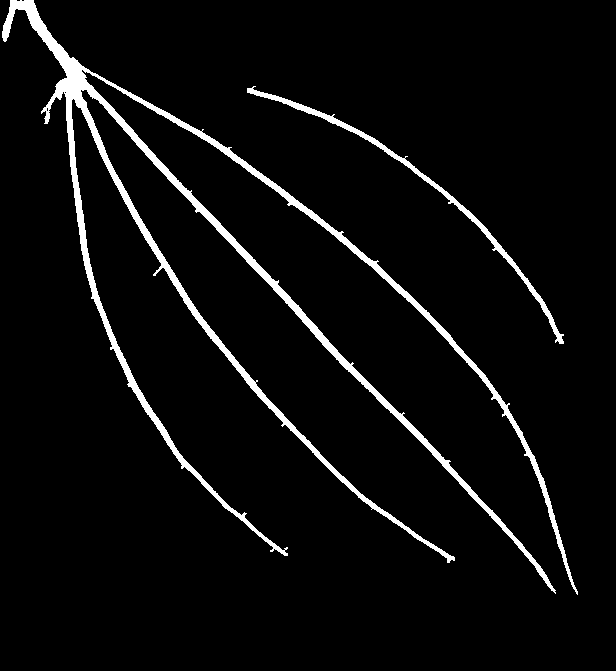

In [96]:
input_dir = '/content/drive/MyDrive/vein_fl_preds (selected)'
output_dir = '/content/drive/MyDrive/output_masks/'

mask_post_processing(input_dir, output_dir)